# Load in libraries

In [1]:
sys.path.insert(0, '/home/566/nd0349/notebooks/functions')
from plotting import create_map_axis, plot_style, add_subplot_label, set_ax_date
from functions import cyclic_moving_av
import datetime as datetime

def ProgressBar(Total, Progress, BarLength=20, ProgressIcon="#", BarIcon="-"):
    try:
        # You can't have a progress bar with zero or negative length.
        if BarLength <1:
            BarLength = 20
        # Use status variable for going to the next line after progress completion.
        Status = ""
        # Calcuting progress between 0 and 1 for percentage.
        Progress = float(Progress) / float(Total)
        # Doing this conditions at final progressing.
        if Progress >= 1.:
            Progress = 1
            Status = "\r\n"    # Going to the next line
        # Calculating how many places should be filled
        Block = int(round(BarLength * Progress))
        # Show this
        Bar = "[{}] {:.0f}% {}".format(ProgressIcon * Block + BarIcon * (BarLength - Block), round(Progress * 100, 0), Status)
        return Bar
    except:
        return "ERROR"


def ShowBar(Bar):
    sys.stdout.write(Bar)
    sys.stdout.flush()
    
from sklearn.neighbors import KernelDensity

In [2]:
# Plot settings
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
textwidth = 3.31314*2
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

#plt.style.use("seaborn")


plt.style.use('default')
plt.style.use(['science','ieee', 'grid'])
sns.set_context("paper")
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
font_size = 14
mpl.rcParams.update({'font.size': font_size})
mpl.rcParams.update({"axes.grid" : True, "grid.color": [0.6, 0.6, 0.6]})
#sns.color_palette("colorblind",15)

#filename = '/g/data/ia40/sea-ice-classification/kmean_2019.nc'
#ds_mask = xr.open_dataset(filename)
#LT = ds_mask['LAT']
#LN = ds_mask['LON']

#del ds_mask

# Format SWH and aice into a new netcdf file

In [3]:
# Save SWH and aice over time into a new netcdf
savepath_nc = '/g/data/ia40/miz-width/'
savefilename = savepath_nc + 'waves-2012.nc'
# Parameters
case = 'waves-025'
mypath = '/g/data/ia40/cice-dirs/runs/' + case + '/history/'
year = 2015
if case == 'waves-025':
    deltaTime = 'd'
    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    title_netcdf = "Daily waves from CICE-WIM standalone 1/4-degree data"
elif case == 'waves-10':
    deltaTime = 'd'
    onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
    title_netcdf = "Daily waves from CICE-WIM standalone 1-degree data"
else:
    deltaTime = 'h'
    onlyfiles = glob.glob("{path}/iceh_01h.*{year}*".format(path=mypath, year=year))
    title_netcdf = "Hourly waves from CICE-WIM standalone 1/4-degree data"

# Start
os.chdir(mypath)
file_dates = []
print(year)
#filename =  mypath + 'iceh_01h.' + str(year) + '-09-01-03600.nc'

onlyfiles.sort()
filename = onlyfiles[0]
ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0

# Initialise arrays
n_lon,n_lat = LN.shape
n_days = len(onlyfiles)
print(n_days)
#n_days = 24 # 720 hours in September
aice_array =  np.empty((n_days,n_lon,n_lat))
swh_array =  np.empty((n_days,n_lon,n_lat))
ppd_array =  np.empty((n_days,n_lon,n_lat))
# Loop over every file
day_vec = range(0,n_days,1)
file_dates = []

# Circumpolar for each day
for day_idx in tqdm(day_vec, total=len(day_vec), desc='Loading aice, swh, ppd data...'):
    filename = onlyfiles[day_idx]
    if deltaTime == 'h':
        file_dates.append(np.datetime64(filename[-19:-9]))
    else:
        file_dates.append(np.datetime64(filename[-13:-3]))
    ds = xr.open_dataset(filename)
    aice_array[day_idx,:,:] = ds.aice.values
    swh_array[day_idx,:,:] = ds.wave_sig_ht.values
    ppd_array[day_idx,:,:] = ds.peak_period.values
            


# Save to netCDF
ds = xr.open_dataset(filename)
HTE = ds.HTE.values
HTN = ds.HTN.values
tarea = ds.tarea.values
tmask = ds.tmask.values

d_vars = {"aice" : (['time','nj','ni'],aice_array,
                              {'long_name' :"Areal sea ice area proportion of cell",
                               'units'     :"-",
                               '_FillValue':-2e8}),
          "wave_sig_ht" : (['time','nj','ni'],swh_array,
                              {'long_name' :"Signficant wave height",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "peak_period" : (['time','nj','ni'],ppd_array,
                              {'long_name' :"Peak period",
                               'units'     :"s",
                               '_FillValue':-2e8}),
          "HTE" : (['nj','ni'],HTE,
                          {'long_name':"T cell width on East side",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "HTN" : (['nj','ni'],HTN,
                          {'long_name':"T cell width on North side",
                           'units'    :"m",
                           '_FillValue':-2e8}),
          "tarea" : (['nj','ni'],tarea,
                          {'long_name':"area of T grid cells",
                           'units'    :"m^2",
                           '_FillValue':-2e8}),
          "tmask" : (['nj','ni'],tmask,
                          {'long_name':"ocean grid mask",
                           'units'    :"Boolean",
                           '_FillValue':-2e8})}

coords = {"LON"  : (["nj","ni"],LN,{'units':'degrees_east'}),
          "LAT"  : (["nj","ni"],LT,{'units':'degrees_north'}),
          "time" : (["time"],file_dates)}
attrs = {'creation_date': datetime.datetime.now().strftime('%Y-%m-%d'),
         'conventions'  : "",
         'title'        : title_netcdf,
         'source'       : ", ",
         'comment'      : "",
         'author'       : 'Noah Day',
         'email'        : 'noah.day@adelaide.edu.au'}
enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
nc_out = xr.Dataset(data_vars=d_vars,coords=coords,attrs=attrs)
write_job = nc_out.to_netcdf(savefilename,unlimited_dims=['time'],compute=False)

2015
365


Loading aice, swh, ppd data...: 100%|██████████| 365/365 [02:49<00:00,  2.15it/s]


# Calculate and save SWH penetration

In [4]:
# Parameters
mypath = '/g/data/ia40/cice-dirs/runs/waves-025/history/'
year = 2015

# Start
os.chdir(mypath)
file_dates = []
print(year)
#filename =  mypath + 'iceh_01h.' + str(year) + '-09-01-03600.nc'
filename =  mypath + 'iceh.' + str(year) + '-09-01.nc'

#onlyfiles = glob.glob("{path}/iceh_01h.*{year}*".format(path=mypath, year=year))
onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
onlyfiles.sort()
filenames = onlyfiles[0:2]
timestep = 'daily'

ds = xr.open_dataset(filenames[0])
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0
# Initialise arrays
n_lat,n_lon = LN.shape
n_days = len(onlyfiles)
print(n_days)
#SIA = np.empty((n_days))
#SIE = np.empty((n_days))

wave_penetration_array = np.empty((n_days,n_lon))
effective_wave_penetration_array = np.empty((n_days,n_lon))
incident_swh_array = np.empty((n_days,n_lon))


# Open the file
for idx, file in tqdm(enumerate(onlyfiles), total = len(onlyfiles)):
    #print(file)
    ones_array = xr.DataArray(np.ones((ds.HTE.shape)), dims=["nj", "ni"])
    
    if timestep == 'daily':
        file_dates.append(np.datetime64(file[-13:-3]))
    elif timestep == 'monthly':
         file_dates.append(np.datetime64(file[-10:-3]))
    ds = xr.open_dataset(file)
    lat = ds.TLAT
    hte = ds.HTE
    
    # 1. Take the Southern hemisphere
    hte = ds.HTE.where(lat<0, drop=True).squeeze() 
    aice_south = ds.aice.where(lat<0, drop=True).squeeze() 
    swh_south = ds.wave_sig_ht.where(lat<0, drop=True).squeeze() 
    wave_penetration_temp = ones_array.where(lat<0, drop=True).squeeze() 

    # 2. aice > 0.15
    hte = hte.where(aice_south > 0.15, drop=False)
    aice = aice_south.where(aice_south > 0.15, drop=False)
    swh_aice = swh_south.where(aice_south > 0.15, drop=False)
    wave_penetration_temp_aice = wave_penetration_temp.where(aice_south > 0.15, drop=False)

    aice_weighted_array_np = np.multiply(aice, hte)
                                         
    # 3. SWH > 5 cm
    hte = hte.where(swh_aice > 0.05, drop=False)
    aice = aice.where(swh_aice > 0.05, drop=False)
    wave_penetration_temp_wave = wave_penetration_temp_aice.where(swh_aice > 0.05, drop=False)
    swh = swh_aice.where(swh_aice > 0.05, drop=False)
     
    swh_penetration_array_np = np.multiply(wave_penetration_temp_wave, hte)


    idx_aice = aice_weighted_array_np.sum(dim='nj') < 0.0001
    
    wave_penetration_array[idx,:] = swh_penetration_array_np.sum(dim='nj')
    wave_penetration_array[idx, idx_aice] = np.nan
    effective_wave_penetration_array[idx,:] = np.multiply(swh_penetration_array_np, aice).sum(dim='nj')
    effective_wave_penetration_array[idx, idx_aice] = np.nan
    incident_swh_array[idx,:] = swh_south.max(dim='nj')


    
#    print(swh_penetration_array.mean(dim='nj'))
    #print(swh_penetration_array.mean())
    #print(swh_penetration_array_np.mean(dim='nj'))
    # if idx == 0:
    #     df = pd.Series(swh_penetration_array_np.mean(), #(dim='nj'),
    #                    name=str(idx)).to_frame()
    # else:
    #     df.join(pd.Series(swh_penetration_array_np.mean(), #(dim='nj'),
    #                       name=str(idx)))
        
    
    # # First take only the southern hemisphere
    # aice_south = (ds.aice.where(lat<0, drop=True)).squeeze() 
    # # Then take all ice exceeding the ice edge
    # aice_only= aice_south.where(aice_south>0.15, drop=True) 

    # tarea_south = (ds.tarea.where(lat<0, drop=True))
    # tarea_aice_only = tarea_south.where(aice_south>0.15, drop=True)
    # weights = tarea_south#np.multiply(hte_south, aice_south)
    # weights.name = "Areal weights"

    # aice_weighted = aice_south.weighted(weights)
    # SIA[idx] = (aice_weighted.sum(("nj", "ni")).values)/(10**12)
    # SIE[idx] = (tarea_aice_only.sum(("nj", "ni")).values)/(10**12)

2015
365


100%|██████████| 365/365 [03:37<00:00,  1.68it/s]


### Old method

In [7]:
# Improving efficiency
# Parameters
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
year = 2010

# Start
os.chdir(mypath)
file_dates = []
print(year)
#filename =  mypath + 'iceh_01h.' + str(year) + '-09-01-03600.nc'
filename =  mypath + 'iceh.' + str(year) + '-09-01.nc'

#onlyfiles = glob.glob("{path}/iceh_01h.*{year}*".format(path=mypath, year=year))
onlyfiles = glob.glob("{path}/iceh.*{year}*".format(path=mypath, year=year))
onlyfiles.sort()

ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0

# Initialise arrays
n_lat,n_lon = LN.shape
n_days = len(onlyfiles)
print(n_days)
effective_wave_penetration_array = np.empty((n_days,n_lon))
wave_penetration_array = np.empty((n_days,n_lon))
incident_swh_array = np.empty((n_days,n_lon))
#std_swh = np.nanstd(wave_sig_ht)

# Loop over every file
day_vec = range(n_days)#range(244-1,244+29,1)

# Circumpolar for each day
for day_idx in tqdm(day_vec, total=len(day_vec), desc = 'Calculating wave penetration...'):

    filename = onlyfiles[day_idx]
    ds = xr.open_dataset(filename)
    aice = ds.aice.values
    wave_sig_ht = ds.wave_sig_ht.values
    
    for lon_idx in range(0,n_lon):
        # MIZ width
        ice_idx = (ds['aice'][0,:,lon_idx].values > 0.15)
        swh_idx_tmp = ds['wave_sig_ht'][0,:,lon_idx].values > 0.05# std_swh
        swh_idx = swh_idx_tmp*ice_idx*lat_idx
        if swh_idx.any():
            effective_wave_penetration_array[day_idx,lon_idx] = np.multiply(ds['HTE'][swh_idx,lon_idx].data, ds['aice'][0,swh_idx,lon_idx].data).sum()
            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
#            (ds['HTE'][swh_idx,lon_idx]*ds['aice'][0,swh_idx,lon_idx]).data.sum()
        else:
            #print('no waves')
            effective_wave_penetration_array[day_idx,lon_idx] =  0.0 #np.nan
            wave_penetration_array[day_idx,lon_idx] =  0.0 #np.nan
            
          
        if ice_idx.any():
            locs = np.asarray(ice_idx==True).nonzero()
            temp_locs = locs[0]
            incident_swh_array[day_idx,lon_idx] = wave_sig_ht[0,temp_locs[-1],lon_idx]
            #np.nanmax(wave_sig_ht[0,:,lon_idx]) #wave_sig_ht[0,temp_locs[-1],lon_idx]
        else:
            incident_swh_array[day_idx,lon_idx] = 0.0 #np.nan
            
print('Done!')

2010
365


Calculating wave penetration...: 100%|██████████| 365/365 [06:01<00:00,  1.01it/s]

Done!


### Save to netCDF

In [11]:
import datetime as datetime
datetime.datetime.now()

datetime.datetime(2023, 10, 13, 16, 42, 23, 126730)

In [5]:
# Save to netCDF
ds = xr.open_dataset(filename)
HTE = ds.HTE.values
HTN = ds.HTN.values
tarea = ds.tarea.values
tmask = ds.tmask.values

dates = pd.date_range(start="2019-09-01",end="2019-10-01", freq='h')
dates = dates[0:-1]
#dates = pd.date_range(start="2019-01-01",end="2019-12-31", freq='d')


d_vars = {"incident_swh" : (['time','ni'],incident_swh_array,
                              {'long_name' :"Incidental SWH",
                               'units'     :"m",
                               '_FillValue':-2e8}),
          "wave_penetration" : (['time','ni'],wave_penetration_array,
                              {'long_name' :"Wave penetrative distance",
                               'units'     :"km",
                               '_FillValue':-2e8}),
          "effective_wave_penetration" : (['time','ni'],effective_wave_penetration_array,
                              {'long_name' :"Wave penetrative distance",
                               'units'     :"km",
                               '_FillValue':-2e8}),
          # "dates" : (['time'],dates,
          #                     {'long_name' :"Datetime",
          #                      'units'     :"time",
          #                      '_FillValue':-2e8}),
}

coords = {"LON"  : (["ni"],LN[0,:],{'units':'degrees_east'}),
#          "LAT"  : (["nj","ni"],LT,{'units':'degrees_north'}),
          "time" : (["time"],dates)}
attrs = {'creation_date': datetime.datetime.now().strftime('%Y-%m-%d'),#datetime.now().strftime('%Y-%m-%d %H'),
         'conventions'  : "",
         'title'        : "Hourly waves from CICE-WIM standalone 1/4-degree data (Sep. 2019)",
         'source'       : ", ",
         'comment'      : "",
         'author'       : 'Noah Day',
         'email'        : 'noah.day@adelaide.edu.au'}
enc_dict  = {'shuffle':True,'zlib':True,'complevel':5} 
nc_out = xr.Dataset(data_vars=d_vars,attrs=attrs)
savepath_nc = '/g/data/ia40/miz-width/'
savefilename = savepath_nc + 'wave-pen-'+str(year)+'_5cm_025deg.nc'
write_job = nc_out.to_netcdf(savefilename,unlimited_dims=['time'],compute=False)

# Cluster attempt

In [ ]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

In [ ]:
ds = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 25, 'lon': 25, 'time': -1})
ds

In [ ]:
da = ds['air']
da

In [ ]:
da2 = da.groupby('time.month').mean('time')
da3 = da - da2
da3

In [ ]:
import numpy as np
import xarray as xr
import bottleneck

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])



In [ ]:
da_smooth = daice.rolling(time=30).mean().persist()
da_smooth
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr
corr.plot(figsize=(12, 8))

In [ ]:
ds = xr.open_dataset('/g/data/ia40/cice-dirs/runs/waves-025-2019/history/iceh_01h.2019-09-01-03600.nc',
                              chunks={'nj': 1080, 'ni': 1440, 'time': -1})
#('/g/data/ia40/sea-ice-classification/waves-sep-2019.nc')
ds

In [ ]:
dswh = ds['wave_sig_ht']
dswh

In [ ]:
daice = ds['aice']
daice

In [ ]:
# Wave penetration
def wave_calculation_gufunc(swh, aice):
    return aice

def wave_penetration_gufunc(swh, aice):
    swh_ranks = bottleneck.rankdata(swh, axis=-1)
    aice_ranks = bottleneck.rankdata(aice, axis=-1)
    return wave_calculation_gufunc(swh_ranks, aice)

def wave_penetration(swh, aice, dim):
    return xr.apply_ufunc(
        wave_penetration_gufunc, swh, aice,
#        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])




# test = wave_penetration(dswh.chunk({'time': -1}),
#                             daice.chunk({'time': -1}),
#                             'time')

# #test.plot(figsize=(12, 8))
# test[1,1]

da_smooth = dswh.rolling(time=30).mean().persist()
da_smooth
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr
corr.plot(figsize=(12, 8))

In [ ]:
da_smooth = da.rolling(time=30).mean().persist()
da_smooth
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr
corr.plot(figsize=(12, 8))

In [ ]:
ds['wave_sig_ht'][0,:,lon_idx].shape

#locs = np.asarray(ice_idx==True).nonzero()
#locs[1]

#tmp_wave_sig_ht = wave_sig_ht.copy
#tmp_wave_sig_ht[tmp_wave_sig_ht < 0.01] = np.nan
#np.nanstd(tmp_wave_sig_ht)

# (ds['HTE'][swh_idx,lon_idx]*ds['aice'][0,swh_idx,lon_idx]).data.sum()


# print(wave_sig_ht[0,lon_idx,temp_locs[-1]])

# wave_sig_ht = ds.wave_sig_ht.values
# wave_sig_ht.max
# wave_sig_ht

# swh_idx_tmp = ds['wave_sig_ht'][0,:,lon_idx].values > 0.38
# swh_idx_tmp

# np.nanmax(wave_sig_ht[0,:,lon_idx])

np.nanstd(wave_sig_ht)
savepath

In [ ]:
cmap[0]

# Make a map

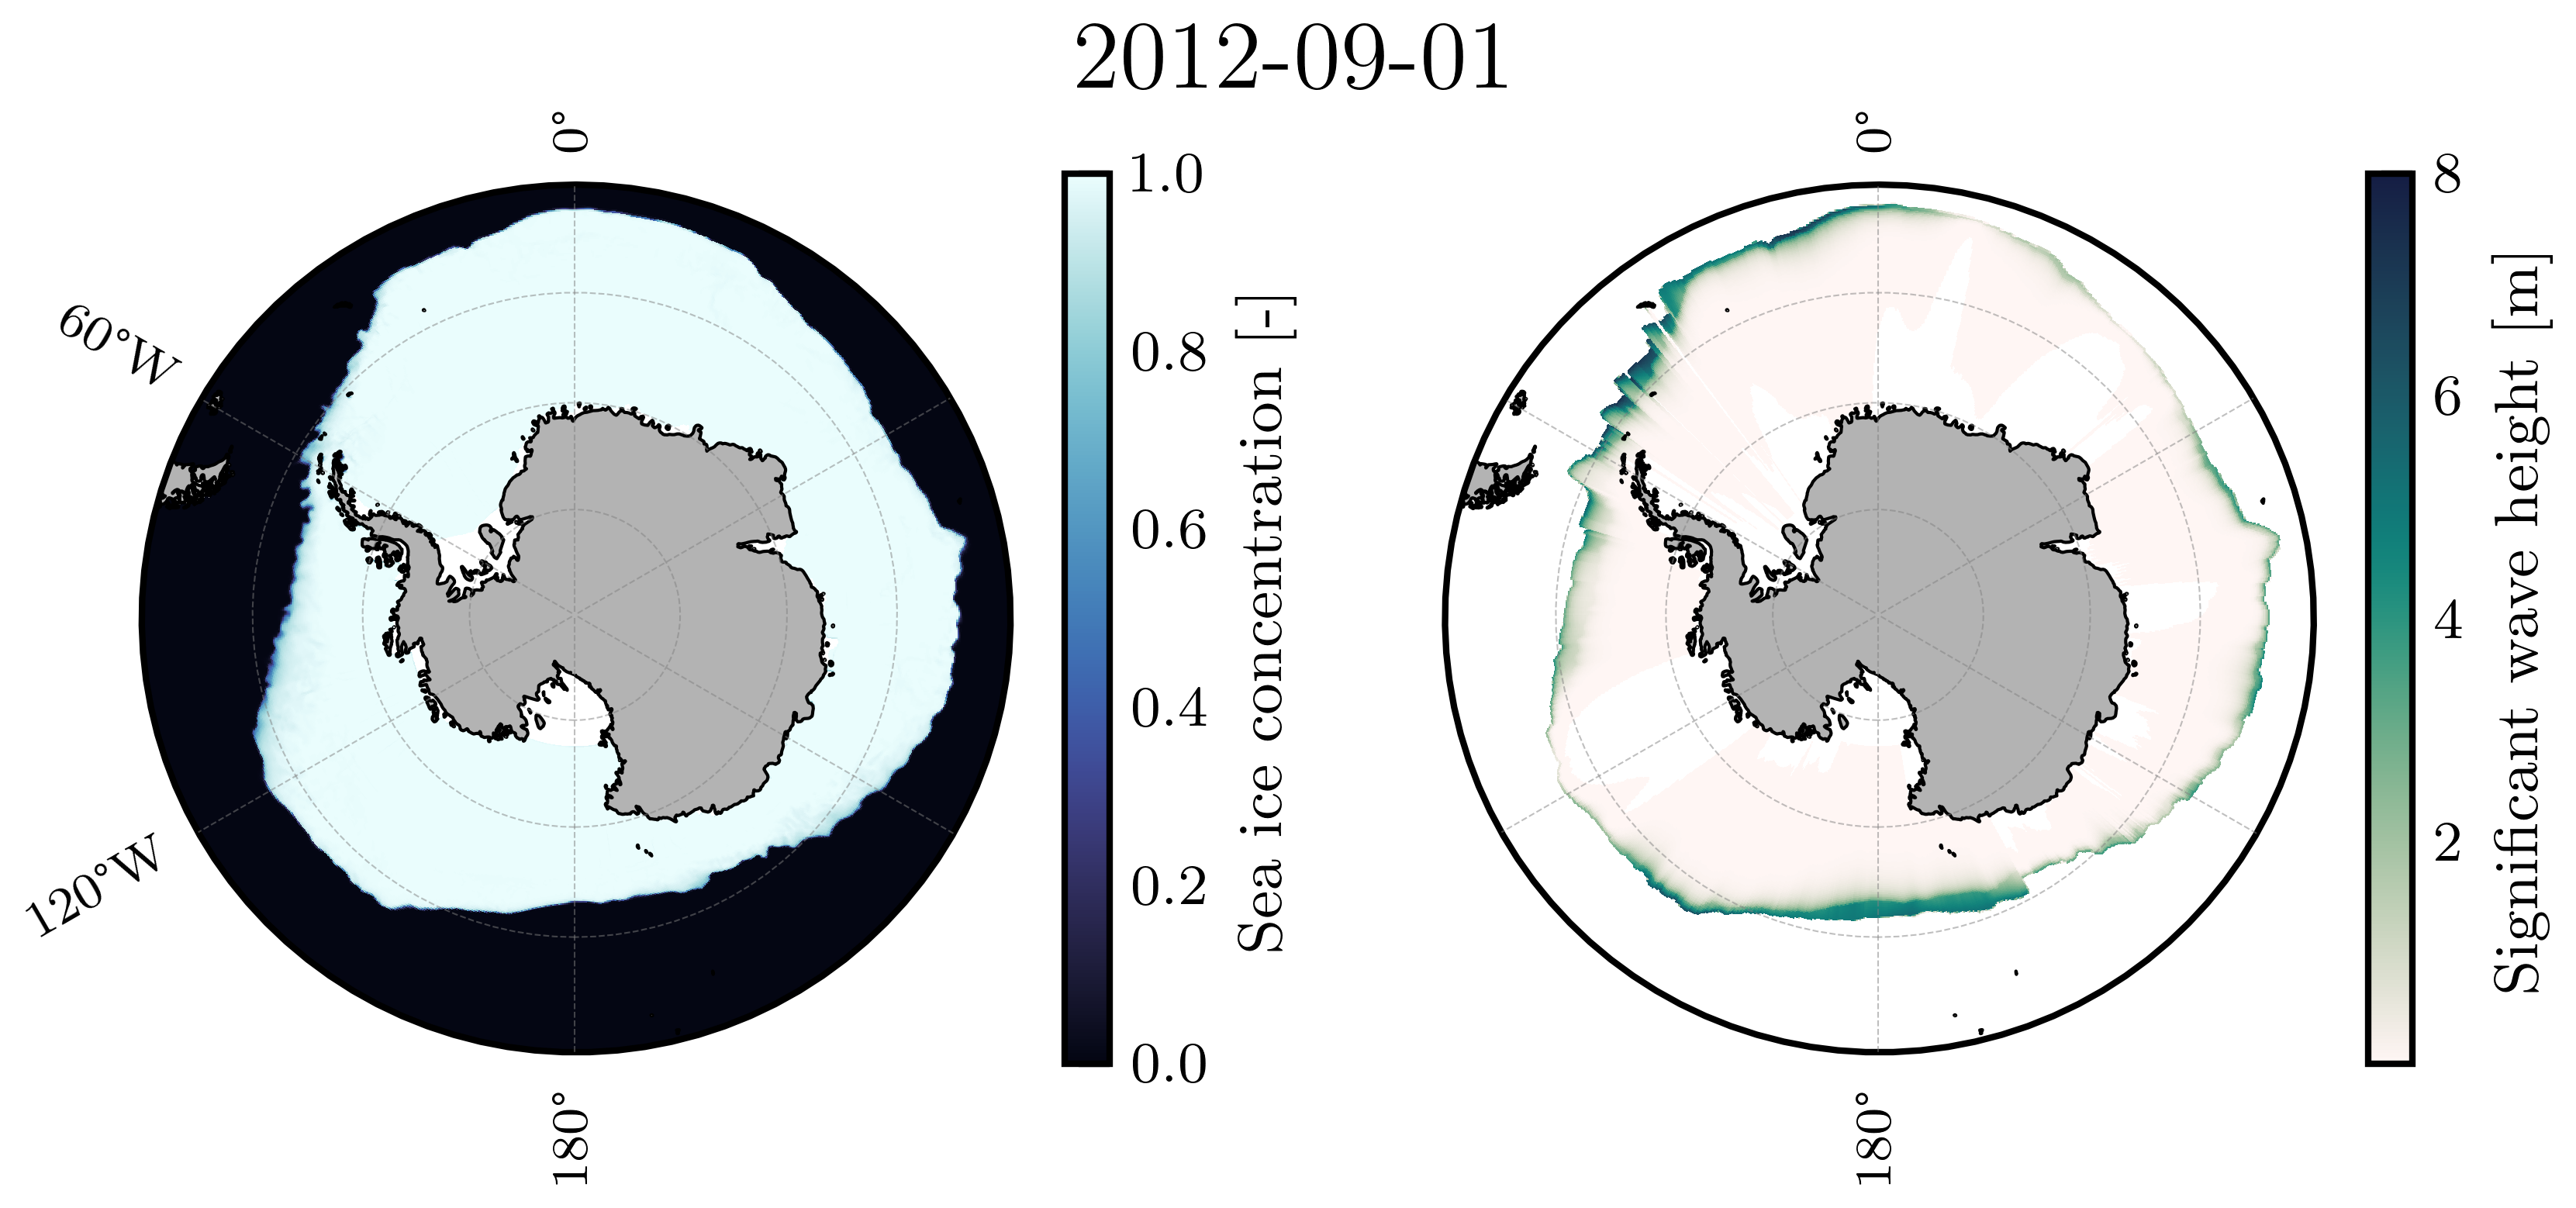

In [5]:
# Plot settings
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
textwidth = 3.31314*2
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

#plt.style.use("seaborn")

plt.style.use('default')
plt.style.use(['science','ieee', 'grid'])
sns.set_context("paper")
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
font_size = 14
mpl.rcParams.update({'font.size': font_size})
mpl.rcParams.update({"axes.grid" : True, "grid.color": [0.6, 0.6, 0.6]})
sns.color_palette("colorblind",15)

savepath = '/home/566/nd0349/notebooks/figures/'

year = 2012
mypath = '/g/data/ia40/cice-dirs/runs/waves-025/history/'
filename = mypath + 'iceh.' + str(year) + '-09-01.nc'

ds_mask = xr.open_dataset(filename)
LT = ds_mask['TLAT']
LN = ds_mask['TLON']
land_mask = ds_mask['tmask'].where(ds_mask['tmask'][:,:] != 1.) 
del ds_mask

ds = xr.open_dataset(filename)
fig = plt.figure(figsize=[width, height/2])
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())

ax1 = create_map_axis(ax=ax1, LN=LN, LT=LT, land_mask=land_mask, draw_labels="left")
ax2 = create_map_axis(ax=ax2, LN=LN, LT=LT, land_mask=land_mask, draw_labels="middle")

#Qfontprops = fm.FontProperties(size=18)
#plt.figure()
cmap = cmo.tempo

cmap.set_bad('white',0.)
cmap.set_over('black',1.0)
cmap.set_under('white',0.)



p = ax1.pcolormesh(LN, LT, ds['aice'][0,:,:],
                transform=ccrs.PlateCarree(),
                cmap=cmo.ice,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')

fig.colorbar(p, ax=ax1, label = 'Sea ice concentration [-]')

p2 = ax2.pcolormesh(LN, LT, ds['wave_sig_ht'][0,:,:],
                transform=ccrs.PlateCarree(),
                cmap=cmap, vmin = 0.000001, vmax = 8,
                shading='auto')
#cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(p2, ax=ax2, label = 'Significant wave height [m]')

temp = filename.partition('.')[2]
fig.suptitle(temp.partition('.')[0], fontsize=15, x=0.5, y = 1.01)

plt.savefig(savepath+'aice_fsdrad_hour.png', dpi = 300)  

In [ ]:
#plt.style.use("ggplot")
ax = plt.subplot()
ax.plot(LT[0:300,0],ds['wave_sig_ht'][0,0:300,0])
#fig.colorbar(density, label='Point density')
plt.ylabel("Significant wave height [m]")
plt.xlabel("Latitude [deg.]")

incident_swh_array[0,0]

# Scatter plot: Wave penetration vs SWH

In [6]:
readpath_nc = '/g/data/ia40/miz-width/'
filename = readpath_nc + 'wave-pen-2015_5cm_025deg.nc' #'wave-pen-sep-2019.nc'
ds_tmp = xr.open_dataset(filename)
wave_penetration_array = np.asarray(ds_tmp['wave_penetration'][:,:])
effective_wave_penetration_array = np.asarray(ds_tmp['effective_wave_penetration'][:,:])
incident_swh_array = np.asarray(ds_tmp['incident_swh'][:,:])
del ds_tmp

#wave_penetration_array[0:-1:10,:].reshape(-1).shape

In [ ]:
#temp_pen[idx]
#wave_penetration_array[0:-1:1,:].reshape(-1).shape

In [ ]:
# Make a density scatter plot
from scipy import stats
from sklearn import linear_model
#temp = wave_penetration_array[:,:].reshape(-1)
#temp_pen = wave_penetration_array[0:10,:]
#temp_swh = incident_swh_array[0:10,:]
temp_pen = wave_penetration_array[0:-1:1,:].reshape(-1)
temp_swh = incident_swh_array[0:-1:1,:].reshape(-1)

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
idx = np.logical_or(idx, (np.abs(temp_swh)<0.01)) # Ignore waves that are smaller than 1 cm
#idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
#idx = temp > 1.0
#plot_swh = incident_swh_array.reshape(-1)[idx]
#temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)

x = plot_swh
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
fig.colorbar(density, label='Probability density')
plt.xlabel("Significant wave height [m]")
plt.ylabel("Wave penetration [km]")
plt.xlim([0, 12])
ax.text(0.70, 0.15, '$R^2= %.2f$' % r2, fontsize=6, transform=ax.transAxes)
ax.text(0.70, 0.05, '$y = %.2f x_1 + %.2f $' % (model.coef_[0], model.intercept_), fontsize=6, transform=ax.transAxes)
#plt.ylim([0, 1000])
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'wave-pen_vs_swh_5cm_2012_025deg.png', dpi = 300)  
plt.show()

(487057,)


In [12]:
(model.intercept_)

array([159.12189206])

In [ ]:
len(plot_wave_pen)

In [ ]:
#plot_swh
eps = 0.2
idx = np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)
plot_swh[idx]

n_bins = 30
fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
# We can set the number of bins with the *bins* keyword argument.
axs.hist(plot_wave_pen[idx]/1000,  bins=n_bins)
plt.xlabel("Effective wave penetration [km]")
plt.ylabel("Frequency")

print(np.mean(plot_wave_pen[idx]/1000))
print(np.std(plot_wave_pen[idx]/1000))

In [ ]:
#idx.shape
#x
#y
temp_pen
#wave_penetration_array[0,:].shape
plot_swh

In [ ]:

wave_penetration_array.shape
onlyfiles[1]
day_vec
LN.shape
LN[1,1:20]
swh_idx

wave_penetration_array
sum(swh_idx)
wave_penetration_array
swh_idx.any()

(ds['aice'][0:100,lon_idx].values > 0.1).all()
#ds['wave_sig_ht'][0:100,lon_idx].values > 0.3

swh_idx.any()
swh_idx[0,200:600]
swh_idx.shape
ds['HTE'].shape
print(lon_idx)


temp = ds['HTE'].values
print(temp.shape)
print(swh_idx.shape)
temp[lon_idx,swh_idx[0,:]]

 
wave_penetration_array

# Hourly CICE data

In [ ]:
# Daily output
## Read in sig. wave height and calculate the penetrative distance

# Parameters
mypath = '/g/data/ia40/cice-dirs/runs/waves-025-2019/history/'
year = 2019

# Start
os.chdir(mypath)
file_dates = []
print(year)
filename =  mypath + 'iceh_01h.' + str(year) + '-09-01-03600.nc'

onlyfiles = glob.glob("{path}/iceh_01h.*{year}*-09-*".format(path=mypath, year=year))
onlyfiles.sort()

# xr.open_mfdataset('my/files/*.nc', parallel=True)

ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0

# Initialise arrays
n_lon,n_lat = LN.shape
n_days = 24 # len(onlyfiles)
print(n_days)
wave_penetration_array = np.empty((n_days,n_lon))
effective_wave_penetration_array = np.empty((n_days,n_lon))
incident_swh_array = np.empty((n_days,n_lon))

std_swh = 0.1 # np.nanstd(wave_sig_ht)
# Loop over every file
day_vec = range(0,n_days,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(day_vec[-1], day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    filename = onlyfiles[day_idx]
    ds = xr.open_dataset(filename)
    aice = ds.aice.values
    wave_sig_ht = ds.wave_sig_ht.values
    
    
    for lon_idx in range(0,n_lon):
        # MIZ width
        ice_idx = (ds['aice'][0,:,lon_idx].values > 0.01)
        swh_idx_tmp = ds['wave_sig_ht'][0,:,lon_idx].values > std_swh
        swh_idx = swh_idx_tmp*ice_idx*lat_idx
        if swh_idx.any():
#            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
            effective_wave_penetration_array[day_idx,lon_idx] = np.multiply(ds['HTE'][swh_idx,lon_idx].data, ds['aice'][0,swh_idx,lon_idx].data).sum()

            # (ds['HTE'][swh_idx,lon_idx]*ds['aice'][0,swh_idx,lon_idx]).data.sum()
        else:
            #print('no waves')
            wave_penetration_array[day_idx,lon_idx] =  np.nan
            effective_wave_penetration_array[day_idx,lon_idx] =  np.nan
            
            
          
        if ice_idx.any():
            locs = np.asarray(ice_idx==True).nonzero()
            temp_locs = locs[0]
            incident_swh_array[day_idx,lon_idx] = np.nanmax(wave_sig_ht[0,:,lon_idx]) #wave_sig_ht[0,temp_locs[-1],lon_idx]
        else:
            incident_swh_array[day_idx,lon_idx] = np.nan
            
print('Done!')    

In [ ]:
np.nanstd(wave_sig_ht)

In [ ]:
# Make a density scatter plot
#temp = wave_penetration_array[:,:].reshape(-1)
temp_pen = wave_penetration_array[:,:]
temp_swh = incident_swh_array[:,:]

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
#idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
#idx = temp > 1.0
#plot_swh = incident_swh_array.reshape(-1)[idx]
#temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)
# Generate fake data
x = plot_swh
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
fig.colorbar(density, label='Density')
plt.xlabel("Significant wave height [m]")
plt.ylabel("Wave penetration [km]")
plt.xlim([0, 12])
plt.ylim([0, 1000])


# now plot both limits against eachother
#ax.plot([0,8], [0,800], 'k-', alpha=0.75, zorder=0)


ax.text(0.75, 0.85, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
ax.text(0.55, 0.75, '$y = %.2f x - %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'wave-pen_vs_swh_hourly_2019-linear.png', dpi = 1000)  
plt.show()

In [ ]:
# Plot the spread of the effective penetration distance given a SWH interval
eps = 0.2
idx = np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)
d = {'swh':plot_swh[idx], 'wave_pen': plot_wave_pen[idx]}
df_wave_pen = pd.DataFrame(data=d)

In [ ]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")
n_bins = 30
fig, axs = plt.subplots(sharey=True, tight_layout=True)
# # We can set the number of bins with the *bins* keyword argument.
eps = 0.5
idx = np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)
axs.hist(plot_wave_pen[idx]/1000,  bins=n_bins, density = True)
plt.xlabel("Effective wave penetration [km]")
plt.ylabel("Frequency")

#fig, ax = plt.subplots()

# Density Plot and Histogram of wave penetration distances given SWH around 3m
#sns.histplot(data=df_wave_pen, x="wave_pen", kde=True, binwidth=0.1)
#plt.xlim([0, 10])

#ax.set_xlabel('"Effective wave penetration [km]"')
#ax.set_ylabel('Probability density')

# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
plt.show()

print(np.mean(plot_wave_pen[idx]/1000))
print(np.std(plot_wave_pen[idx]/1000))

In [ ]:
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")
n_bins = 30


eps = 0.2
data = {
    '1' : plot_wave_pen[np.logical_and(plot_swh>1.0-eps, plot_swh<1.0+eps)],
    '2' : plot_wave_pen[np.logical_and(plot_swh>2.0-eps, plot_swh<2.0+eps)],
    '3' : plot_wave_pen[np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)],
    '4' : plot_wave_pen[np.logical_and(plot_swh>4.0-eps, plot_swh<4.0+eps)],
    '5' : plot_wave_pen[np.logical_and(plot_swh>5.0-eps, plot_swh<5.0+eps)],
    '6' : plot_wave_pen[np.logical_and(plot_swh>6.0-eps, plot_swh<6.0+eps)],
    '7' : plot_wave_pen[np.logical_and(plot_swh>7.0-eps, plot_swh<7.0+eps)],
    '8' : plot_wave_pen[np.logical_and(plot_swh>8.0-eps, plot_swh<8.0+eps)],
}


#sns.histplot(data=plot_wave_pen[idx]/1000, kde=True, bins=n_bins)
fig, axs = plt.subplots(3,1,sharey=True, tight_layout=True)
sns.histplot(data=data['2']/1000, kde=True, bins=n_bins, ax=axs[0])
axs[0].set_title('SWH $= 2\pm 0.2$ m, $\mu = %.2f$, $\sigma=%.2f$' %(np.mean(data['2']/1000), np.std(data['2']/1000)), fontsize=12)
sns.histplot(data=data['3']/1000, kde=True, bins=n_bins, ax=axs[1])
axs[1].set_title('SWH $= 3\pm 0.2$ m, $\mu = %.2f$, $\sigma=%.2f$' %(np.mean(data['3']/1000), np.std(data['3']/1000)), fontsize=12)
sns.histplot(data=data['4']/1000, kde=True, bins=n_bins, ax=axs[2])
axs[2].set_title('SWH $= 4\pm 0.2$ m, $\mu = %.2f$, $\sigma=%.2f$' %(np.mean(data['4']/1000),np.std(data['4']/1000)), fontsize=12)
plt.xlabel("Wave penetration [km]")
plt.ylabel("Count")
# Tweak spacing to prevent clipping of ylabel
#fig.tight_layout()
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'histogram.png', dpi = 300)  
plt.show()

print(np.mean(plot_wave_pen[idx]/1000))
print(np.std(plot_wave_pen[idx]/1000))



In [ ]:
fig, axs = plt.subplot_mosaic([['a)','b)', 'c)']],
                              nrows=3,ncols=1,
                              subplot_kw={'projection': ccrs.SouthPolarStereo()},
                              figsize=(12,4.5))
plt.rcParams["font.family"] = "serif"
n_clusters = 2
for label, ax in axs.items():
    readfilename='/g/data/ia40/sea-ice-classification/kmean_'+str(n_clusters)+'_clusters_'+str(year)+'.nc'
    ds = xr.open_dataset(readfilename)
    plot_data = ds['k'][243,:,:]
    cs = ax.pcolormesh(ds['LON'][:,:], ds['LAT'][:,:], plot_data,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                norm=norm,
                shading='auto')

    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='large', verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.0', edgecolor='none', pad=3.0))
    ax.set_extent(coord_lims, ccrs.PlateCarree())
    
    # Add coastlines
    ax.add_feature(land_50m)
    ax.coastlines()
    n_clusters = n_clusters + 1

In [ ]:
# Violin plot
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")

eps = 0.5
data = {
    '1' : plot_wave_pen[np.logical_and(plot_swh>1.0-eps, plot_swh<1.0+eps)],
    '2' : plot_wave_pen[np.logical_and(plot_swh>2.0-eps, plot_swh<2.0+eps)],
    '3' : plot_wave_pen[np.logical_and(plot_swh>3.0-eps, plot_swh<3.0+eps)],
    '4' : plot_wave_pen[np.logical_and(plot_swh>4.0-eps, plot_swh<4.0+eps)],
    '5' : plot_wave_pen[np.logical_and(plot_swh>5.0-eps, plot_swh<5.0+eps)],
    '6' : plot_wave_pen[np.logical_and(plot_swh>6.0-eps, plot_swh<6.0+eps)],
    '7' : plot_wave_pen[np.logical_and(plot_swh>7.0-eps, plot_swh<7.0+eps)],
    '8' : plot_wave_pen[np.logical_and(plot_swh>8.0-eps, plot_swh<8.0+eps)],
}
maxsize = max([a.size for a in data.values()])
data_pad = {k:np.pad(v, pad_width=(0,maxsize-v.size,), mode='constant', constant_values=np.nan) for k,v in data.items()}
df = pd.DataFrame(data_pad)

plt.style.use("ggplot")
fig, ax = plt.subplots()
sns.violinplot(data=df/1000, cut=0,inner=None,scale="area")
ax.set_xlabel('Significant wave height [m]')
ax.set_ylabel('Wave penetration [km]')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'violin_plot.png', dpi = 300)  
plt.show()

In [ ]:

# set seaborn style
#sns.set_style("white")

plt.style.use("ggplot")
fig, ax = plt.subplots()

# # Basic 2D density plot
# sns.kdeplot(x=df.swh, y=df.wave_pen)
# plt.show()
 
# Custom the color, add shade and bandwidth
sns.kdeplot(x=df.swh, y=df.wave_pen, cmap="Reds", fill=True, bw_adjust=.5)
ax.set_xlabel('Significant wave height [m]')
ax.set_ylabel('Wave penetration distance [km]')
plt.show()


# # Add thresh parameter
# sns.kdeplot(x=df.swh, y=df.wave_pen, cmap="Blues", fill=True, thresh=0)
plt.show()

In [ ]:
d = {'swh':plot_swh, 'wave_pen': plot_wave_pen/1000}
df = pd.DataFrame(data=d)

In [ ]:

from scipy.stats import kde

#xi, yi, zi, = x_kde, y_kde, z_kde

x=df.swh
y=df.wave_pen

nbins = 500

k = gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


In [ ]:
# Make the 2D density plot
# https://www.python-graph-gallery.com/85-density-plot-with-matplotlib
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.style.use("ggplot")
fig, ax = plt.subplots()
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap = plt.cm.PuBu_r)#,#cmap=cmo.dense)#,
#               norm=colors.LogNorm(vmin=0.00000001, vmax=0.0001))
plt.colorbar(extend=None, label='Density')
ax.set_xlabel('Significant wave height [m]')
ax.set_ylabel('Wave penetration [km]')
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'2d_density.png', dpi = 300)  
plt.show()

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

d = {'swh':plot_swh, 'wave_pen': plot_wave_pen/1000}
df = pd.DataFrame(data=d)
# set seaborn style
#sns.set_style("white")

plt.style.use("ggplot")

# # Basic 2D density plot
# sns.kdeplot(x=df.swh, y=df.wave_pen)

# Simulate data from a bivariate Gaussian
#n = 10000
#mean = [0, 0]
#cov = [(2, .4), (.4, .2)]
#rng = np.random.RandomState(0)
#x, y = rng.multivariate_normal(mean, cov, n).T
x=df.swh
y=df.wave_pen
# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
rs = np.random.RandomState(50)

# Set up the matplotlib figure
f, axes = plt.subplots(3, 3, figsize=(9, 9), sharex=True, sharey=True)

# Rotate the starting point around the cubehelix hue circle
for ax, s in zip(axes.flat, np.linspace(0, 3, 10)):

    # Create a cubehelix colormap to use with kdeplot
    cmap = sns.cubehelix_palette(start=s, light=1, as_cmap=True)

    # Generate and plot a random bivariate dataset
#    x, y = rs.normal(size=(2, 50))
    sns.kdeplot(
        x=x, y=y,
        cmap=cmap, fill=True,
        clip=(-5, 5), cut=10,
        thresh=0, levels=15,
        ax=ax,
    )
    ax.set_axis_off()

ax.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5))
f.subplots_adjust(0, 0, 1, 1, .08, .08)

In [ ]:
np.asarray(zi).shape

In [ ]:
df_wave_pen["wave_pen"].shape
#wave_penetration_array.shape

In [ ]:
# example data
plt.style.use("ggplot")
mu = 100  # mean of distribution
sigma = 15  # standard deviation of distribution
x = mu + sigma * np.random.randn(437)

num_bins = 50

fig, ax = plt.subplots()

# the histogram of the data
n, bins, patches = ax.hist(x, num_bins, density=True)

# add a 'best fit' line
y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
     np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
ax.plot(bins, y, '--')
ax.set_xlabel('Smarts')
ax.set_ylabel('Probability density')
ax.set_title(r'Histogram of IQ: $\mu=100$, $\sigma=15$')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()


## k-means vs wave penetration

In [ ]:
# Daily output
## Read in sig. wave height and calculate the penetrative distance

# Parameters
mypath = '/g/data/ia40/cice-dirs/runs/waves-10/history/'
year = 2015

# Start
os.chdir(mypath)
file_dates = []
print(year)
filename =  mypath + 'iceh.' + str(year) + '-01-01.nc'

onlyfiles = glob.glob("{path}/iceh.*{year}*-09-*".format(path=mypath, year=year))
onlyfiles.sort()

# xr.open_mfdataset('my/files/*.nc', parallel=True)

ds = xr.open_dataset(filename)
LN = ds.TLON.values
LT = ds.TLAT.values
lat_idx = LT[:,0] < 0

ds_tmp = xr.open_dataset('/g/data/ia40/sea-ice-classification/kmean_' + str(year) + '.nc')
k_array = ds_tmp['k'][243:(243+30),:,:]

# Initialise arrays
n_lat,n_lon = LN.shape
n_days = len(onlyfiles)
print(n_days)
wave_penetration_array = np.empty((n_days,n_lon))
effective_wave_penetration_array = np.empty((n_days,n_lon))
incident_swh_array = np.empty((n_days,n_lon))
miz_width_array = np.empty((n_days,n_lon))

std_swh = 0.1 # np.nanstd(wave_sig_ht)
# Loop over every file
day_vec = range(0,n_days,1)

# Circumpolar for each day
for day_idx in day_vec:
    progressBar = "\rProgress: " + ProgressBar(day_vec[-1], day_idx+1, 20, '#', '.')
    ShowBar(progressBar)
    filename = onlyfiles[day_idx]
    ds = xr.open_dataset(filename)
    aice = ds.aice.values
    wave_sig_ht = ds.wave_sig_ht.values
    
    
    for lon_idx in range(0,n_lon):
        # MIZ width
        ice_idx = (ds['aice'][0,:,lon_idx].values > 0.01)
        swh_idx_tmp = ds['wave_sig_ht'][0,:,lon_idx].values > std_swh
        swh_idx = swh_idx_tmp*ice_idx*lat_idx
        
        miz_idx = (k_array[day_idx,:,lon_idx].values == 0)*ice_idx
        if swh_idx.any():
#            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
            wave_penetration_array[day_idx,lon_idx] = ds['HTE'][swh_idx,lon_idx].data.sum()
            effective_wave_penetration_array[day_idx,lon_idx] = np.multiply(ds['HTE'][swh_idx,lon_idx].data, ds['aice'][0,swh_idx,lon_idx].data).sum()
            # (ds['HTE'][swh_idx,lon_idx]*ds['aice'][0,swh_idx,lon_idx]).data.sum()
        else:
            #print('no waves')
            wave_penetration_array[day_idx,lon_idx] =  np.nan
            effective_wave_penetration_array[day_idx,lon_idx] =  np.nan
            
            
          
        if ice_idx.any():
            locs = np.asarray(ice_idx==True).nonzero()
            temp_locs = locs[0]
            incident_swh_array[day_idx,lon_idx] = np.nanmax(wave_sig_ht[0,:,lon_idx]) #wave_sig_ht[0,temp_locs[-1],lon_idx]
        else:
            incident_swh_array[day_idx,lon_idx] = np.nan
            
            
        if miz_idx.any():
            miz_width_array[day_idx,lon_idx] = np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][0,miz_idx,lon_idx].data).sum()
            #ds['HTE'][miz_idx,lon_idx].data.sum ()
            #np.multiply(ds['HTE'][miz_idx,lon_idx].data, ds['aice'][0,miz_idx,lon_idx].data).sum()
        else:
            miz_width_array[day_idx,lon_idx] = np.nan
            
print('Done!')    

In [ ]:
print(miz_idx.shape)
#print(sic_idx.shape)
(k_array[day_idx,:,lon_idx].values == 0).shape

#ds['HTE'][miz_idx,lon_idx]
ds['HTE'].shape
lon_idx
miz_idx

In [ ]:
# Make a density scatter plot
#temp = wave_penetration_array[:,:].reshape(-1)
temp_pen = effective_wave_penetration_array[:,:]
#wave_penetration_array[:,:]
temp_swh = incident_swh_array[:,:]

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
#idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
#idx = temp > 1.0
#plot_swh = incident_swh_array.reshape(-1)[idx]
#temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)
# Generate fake data
x = plot_swh
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
#ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
fig.colorbar(density, label='Density')
plt.xlabel("Significant wave height [m]")
plt.ylabel("Effective wave penetration [km]")
plt.xlim([0, 12])
plt.ylim([0, 1000])


# now plot both limits against eachother
ax.plot([0,8], [0,800], 'k-', alpha=0.75, zorder=0)


#ax.text(0.75, 0.85, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
#ax.text(0.55, 0.75, '$y = %.2f x - %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'wave-pen_vs_swh_daily_1deg_'+str(year)+'.png', dpi = 1000)  
plt.show()

In [ ]:
# Read in MIZ width
filename = '/g/data/ia40/sea-ice-classification/mizWidth_2018.nc'
ds = xr.open_dataset(filename)

range(243,243+30)

# Make a density scatter plot
#temp = wave_penetration_array[:,:].reshape(-1)
temp_pen = miz_width_array[:,:]
temp_swh = incident_swh_array[:,:]

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
idx = np.logical_or(idx, (np.abs(temp_pen)<100)) 
# #idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
# idx = temp_swh > 1.0
# #plot_swh = incident_swh_array.reshape(-1)[idx]
# #temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)

#plot_swh = temp_swh.reshape(-1)
#plot_wave_pen = temp_pen.values.reshape(-1)



x = plot_swh
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x,y,z#x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
#ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
fig.colorbar(density, label='Density')
plt.xlabel("Significant wave height [m]")
plt.ylabel("Effective MIZ width [km]")
plt.xlim([0, 12])
plt.ylim([0, 500])


# now plot both limits against eachother
ax.plot([0,8], [0,800], 'k-', alpha=0.75, zorder=0)


#ax.text(0.75, 0.85, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
#ax.text(0.55, 0.75, '$y = %.2f x - %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'miz_width_vs_swh_daily_1deg_'+str(year)+'.png', dpi = 1000)  
plt.show()

In [ ]:
# Read in MIZ width
filename = '/g/data/ia40/sea-ice-classification/mizWidth_2018.nc'
ds = xr.open_dataset(filename)

range(243,243+30)

# Make a density scatter plot
#temp = wave_penetration_array[:,:].reshape(-1)
temp_pen = effective_wave_penetration_array[:,:]
temp_swh = miz_width_array[:,:]

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
idx = np.logical_or(idx, (np.abs(temp_swh)<100)) 
# #idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
# idx = temp_swh > 1.0
# #plot_swh = incident_swh_array.reshape(-1)[idx]
# #temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)

#plot_swh = temp_swh.reshape(-1)
#plot_wave_pen = temp_pen.values.reshape(-1)

x = plot_swh/1000
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x,y,z#x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")


nbins = 500

k = gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


In [ ]:

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
#density = ax.scatter(x_kde, y_kde, c=z_kde, s=20)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap = plt.cm.PuBu_r,#cmap=cmo.dense)#,
               norm=colors.LogNorm(vmin=0.000001, vmax=0.00003))
plt.colorbar(extend='both', label='Density')
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
#ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
#fig.colorbar(density, label='Density')
plt.xlabel("Effective MIZ width [km]")
plt.ylabel("Effective wave penetration [km]")

#plt.xlim([0, 500])
#plt.ylim([0, 500])

# now plot both limits against eachother
#ax.plot([0,800], [0,800], 'k-', alpha=0.75, zorder=0)


#ax.text(0.75, 0.85, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
#ax.text(0.55, 0.75, '$y = %.2f x - %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'wave_pen_vs_miz_daily_color_1deg_'+str(year)+'.png', dpi = 1000)  
plt.show()

In [ ]:
# filename = '/g/data/ia40/sea-ice-classification/mizWidth_2018.nc'
# ds = xr.open_dataset(filename)

# print(incident_swh_array.shape)

# print(ds['absolute'][243:273,:].shape)

# print(LN[0,:].shape)

# n_lon,n_lat = LN.shape
# print(n_lon)
# print(n_lat)
temp_pen[idx]

In [ ]:
temp_swh.reshape(-1)
temp_pen.values.reshape(-1)

temp_pen.shape

temp_swh.shape

ds_tmp = xr.open_dataset('/g/data/ia40/sea-ice-classification/kmean_2018.nc')
k_array = ds_tmp['k'][243:(243+30),:,:]
k_array.shape

# Movies

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import os
import glob
from PIL import Image
import sys
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
import IPython.display

# Plotting
import scienceplots
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.colors as colors
import matplotlib as mpl
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.dates as mdates
import plotly.express as px
from matplotlib.ticker import NullFormatter
from matplotlib import rc
import seaborn as sns
import matplotlib.transforms as mtransforms
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.transforms as mtransforms
import seaborn as sns
import matplotlib.path as mpath
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
import cartopy.feature as cfea


def create_map_axis(ax, LN, LT, land_mask, draw_labels="off"):
    COLOR_LAND = (0.7, 0.7, 0.7)
#    fig.subplots_adjust(bottom=0.05, top=0.95,
#                    left=0.04, right=0.95, wspace=0.02)
    # Limit the map to -60 degrees latitude and below.
    coord_lims = [-180, 180, -90, -50]
    ax.set_extent(coord_lims, ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                      linewidth=0.25, color='gray', alpha=0.5, linestyle='--', zorder=4)
    gl.top_labels = False
    gl.bottom_labels = False
    gl.xlines = True
    gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120])
    if draw_labels == "right": # right
        gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.0, linestyle='--')
        gl2.xlocator = mticker.FixedLocator([180, 60, 120, 0])
        gl2.ylocator = mticker.FixedLocator([0])
    elif draw_labels == "left": # left
        gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.0, linestyle='--')
        gl2.xlocator = mticker.FixedLocator([-180, -60, -120, 0])
        gl2.ylocator = mticker.FixedLocator([0])
    elif draw_labels == "middle":
        gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.0, linestyle='--')
        gl2.xlocator = mticker.FixedLocator([-180, 0])
        gl2.ylocator = mticker.FixedLocator([0])
    elif draw_labels == "all":
        gl2 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.0, linestyle='--')
        gl2.xlocator = mticker.FixedLocator([-180, -60, -120, 0, 60, 120])
        gl2.ylocator = mticker.FixedLocator([0])
        

    
    gl.ylocator = mticker.FixedLocator([-80, -70, -60])
    gl2.ylocator = mticker.FixedLocator([0])
    #gl.ylocator = LatitudeLocator()
    gl2.xformatter = LongitudeFormatter()
    gl2.yformatter = LatitudeFormatter()
    gl2.xlabel_style = {'color': 'black', 'weight': 'bold', 'size': 8, 
                      }


    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    
    land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor=COLOR_LAND, linewidth=0.5)
    ax.add_feature(land_50m)
    
    ax.plot([180, 180], [-90, -84.6],
                     zorder=3, color=COLOR_LAND,
                     linewidth=0.75,
                     transform=ccrs.PlateCarree())

    
    return ax


def make_gif(frame_folder, gifname, yr, dframe):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))[0:len(glob.glob(f"{frame_folder}/*.png")):dframe]]
    frame_one = frames[0]
    frame_one.save(gifname + str(yr) + ".gif", format="GIF", append_images=frames,
               save_all=True, duration=100, loop=0)

In [ ]:
year = 2019
COLOR_MIZ = [0.9805, 0.5000, 0.4453, 1.0]
COLOR_FSD = sns.color_palette("colorblind",15)[2]
COLOR_WAVE = sns.color_palette("colorblind",15)[3]
COLOR_IAGE = sns.color_palette("colorblind",15)[4]
COLOR_INTERIOR = sns.color_palette("colorblind",15)[0]

# Plot settings
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
textwidth = 3.31314*2
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

#plt.style.use("seaborn")


plt.style.use('default')
plt.style.use(['science','ieee', 'grid'])
sns.set_context("paper")
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
font_size = 14
mpl.rcParams.update({'font.size': font_size})
mpl.rcParams.update({"axes.grid" : True, "grid.color": [0.6, 0.6, 0.6]})
sns.color_palette("colorblind",15)

filename = '/g/data/ia40/sea-ice-classification/kmean_2019.nc'
ds_mask = xr.open_dataset(filename)
LT = ds_mask['LAT']
LN = ds_mask['LON']
land_mask = ds_mask['tmask'].where(ds_mask['tmask'][:,:] != 1.) 
del ds_mask

In [ ]:
mypath = '/g/data/ia40/cice-dirs/runs/waves-025-2019/history' #'/g/data/dy43/cice-dirs/runs/nowaves/history/' + year
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) if f.startswith("iceh_01h."+str(year))]
filenames = sorted(onlyfiles)
filenames = filenames[0:720:1]
plot_dir = '/home/566/nd0349/notebooks/figures/gif'
year = 2019

var = 'aice-fsdrad-swh'
#print(filenames[0])
#print(filenames[-1])
for i, f in enumerate(filenames[:186]):
    if f.startswith("iceh_01h."+str(year)):
        print(f)
        filename = mypath + '/' + f
        ds = xr.open_dataset(filename)
        fig = plt.figure(figsize=[width, height/2])
        ax1 = fig.add_subplot(1, 3, 1, projection=ccrs.SouthPolarStereo())
        ax1 = create_map_axis(ax=ax1, LN=LN, LT=LT, land_mask=land_mask, draw_labels="left")
        ax2 = fig.add_subplot(1, 3, 2, projection=ccrs.SouthPolarStereo())
        ax2 = create_map_axis(ax=ax2, LN=LN, LT=LT, land_mask=land_mask, draw_labels="middle")
        ax3 = fig.add_subplot(1, 3, 3, projection=ccrs.SouthPolarStereo())
        ax3 = create_map_axis(ax=ax3, LN=LN, LT=LT, land_mask=land_mask, draw_labels="middle")
        
        cs = ax1.pcolormesh(ds['TLON'][:,:],ds['TLAT'][:,:],ds['aice'][0,:,:],
                            transform=ccrs.PlateCarree(), shading='auto',
                            cmap=cmo.ice, vmin = 0.0, vmax = 1.0)
#        pos1 = ax1.get_position()
#        fig.subplots_adjust(right=0.8)
#        cbar_ax = fig.add_axes([pos1.x0 + pos1.width + 0.05, pos1.y0, pos1.height/20, pos1.height])
        cbar = fig.colorbar(cs, ax=ax1, orientation='vertical', label='Sea ice concentration [-]')
        
        cs = ax2.pcolormesh(ds['TLON'][:,:],ds['TLAT'][:,:],ds['fsdrad'][0,:,:],
                            transform=ccrs.PlateCarree(), shading='auto',
                            cmap=cmo.matter, norm = colors.LogNorm(vmin=1, vmax=1000))
#        pos1 = ax2.get_position()
#        fig.subplots_adjust(right=0.8)
#        cbar_ax = fig.add_axes([pos1.x0 + pos1.width + 0.05, pos1.y0, pos1.height/20, pos1.height])
        cbar = fig.colorbar(cs, ax=ax2, orientation='vertical', label='Representative floe size [m]')
        
        
        cs = ax3.pcolormesh(ds['TLON'][:,:],ds['TLAT'][:,:],ds['wave_sig_ht'][0,:,:],
                            transform=ccrs.PlateCarree(), shading='auto',
                            cmap=cmo.haline, vmin=0, vmax=10)
#        pos1 = ax3.get_position()
#        fig.subplots_adjust(right=0.8)
#        cbar_ax = fig.add_axes([pos1.x0 + pos1.width + 0.05, pos1.y0, pos1.height/20, pos1.height])
        cbar = fig.colorbar(cs, ax=ax3, orientation='vertical', label='Signficant wave height [m]')
    #    cbar.ax.majorticks_on()
    #    cbar.ax.minorticks_on()

        #ax_cb = plt.axes([0.85, 0.15, 0.03, 0.7])
        #cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
        #ax_cb = plt.axes([0.85, 0.15, 0.03, 0.7])
        #cb = plt.colorbar(p1, orientation='vertical')
        #cb.ax.set_ylabel('Zonal velocity (m/s)');

        sys.stdout.flush()

        #print('Saving figure...')
        temp = filename.partition('.')[2]
        fig.suptitle(temp.partition('.')[0], fontsize=15, x=0.5, y = 1.01)
        plt.savefig(plot_dir + '/' + var + '_01h-' + temp.partition('.')[0]+'.png', dpi = 300)  
        # plt.savefig(temp.partition('.')[0]+'-'+var_name+'.png', dpi = 100)  
       # print('Image saved!')
       # plt.show()


In [ ]:
plot_dir + '/' + var + '_01h-' + temp.partition('.')[0]+'.png'

In [ ]:
frame_folder = '/home/566/nd0349/notebooks/figures/gif/'
var = 'aice-fsdrad-swh'
year = 2019
dframe = 1
gifname = frame_folder + '/' + var + '-'
frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/"+var+"*.png"))[0:len(f"{frame_folder}/"+var+"*.png"):dframe]]
frame_one = frames[0]
frame_one.save(gifname + str(year) + ".gif", format="GIF", append_images=frames,
           save_all=True, duration=100, loop=0)

# ALtiKa data

In [ ]:
number = 1
p = ("%02d" % (number,))
p

In [5]:
month = 2
df = pd.read_csv('/g/data/ia40/miz-width/v0_6/2019' + ("%02d" % (month,)) + '_output_v0_6.csv')
df.head()

first_meas_time    swh15n     lat15n      lon15n    swh14n  \
0  2019-02-01 00:41:39.222654  2.282394 -57.085082  235.325112  2.184947   
1  2019-02-01 03:12:34.679502  3.134977 -51.758970   49.549293  2.868512   
2  2019-02-01 04:53:11.495601  4.378428 -50.713772   23.918165  4.030664   
3  2019-02-01 05:43:30.294488  7.429596 -51.577709  162.745101  6.345542   
4  2019-02-01 06:33:48.233494  2.863687 -52.490026  359.594537  2.917629   

      lat14n      lon14n    swh13n     lat13n      lon13n  ...      lon01n  \
0 -58.085082  234.717263  2.229394 -59.085082  234.077426  ...  221.779864   
1 -52.758970   50.028005  2.920940 -53.758970   50.526352  ...   59.022841   
2 -51.713772   24.377764  4.029252 -52.713772   24.855019  ...   32.853608   
3 -52.577709  162.270124  7.801584 -53.577709  161.775063  ...  153.367846   
4 -53.490026    0.087708  2.869318 -54.490026    0.601747  ...    9.485280   

   swhAtMyEdge  latAtMyEdge  lonAtMyEdge  latAtAltiKaEdge  lonAtAltiKaEdge  \
0     0.774676   -72.085082   220.025362       -73.684785       216.733174   
1     1.684591   -66.758970    60.077806       -66.780904        60.101786   
2     1.431704   -65.713772    33.827370       -67.712749        36.019857   
3     1.188934   -66.577709   152.327036       -66.938986       151.930148   
4     0.949628   -67.490026    10.606071       -69.122262        12.659393   

   latAtInnerMIZ  lonAtInnerMIZ  mizWidthAlongTrackFromMyEdge  \
0     -73.836331     216.382301                    228.828561   
1     -66.902213      60.237682                     17.449702   
2     -67.770837      36.083253                    249.987201   
3     -67.510572     151.280824                    113.567221   
4     -69.338862      12.956487                    227.660453   

   mizWidthAlongTrackFromAltikaEdge  
0                         20.152209  
1                         14.785540  
2                          7.011428  
3                         69.648418  
4                         26.872973  

[5 rows x 55 columns]

In [10]:
# Read in AltiKa
month_range = range(1,13)
df = pd.concat((pd.read_csv('/g/data/ia40/miz-width/v0_6/2019' + ("%02d" % (month,)) + '_output_v0_6.csv') 
                for month in tqdm(month_range, total = len(month_range), desc = "Reading in Alex's data")),
                ignore_index=True)

df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
df.head(5)

df['date'] = pd.to_datetime(df["first_meas_time"], format='%Y-%m-%d')
#df["first_meas_time"]
df['day'] = pd.to_datetime(df['date']).dt.day
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df.groupby(['month'],as_index=False).mean().head()

# Read in CICE-WIM wave penetration
year = 2015
readfilename =  '/g/data/ia40/miz-width/wave-pen-'+str(year)+'_5cm_025deg.nc'
cice_wave_pen = xr.open_dataset(readfilename)
data_xr = xr.DataArray(cice_wave_pen.wave_penetration[0:365,:]/1000, dims=["time", "ni"])
n_day,n_lon = data_xr.shape

dates = pd.date_range(start="2019-01-01",end="2019-12-31", freq='d')
np.tile(pd.to_datetime(dates[0:n_day]),(n_lon,1)).reshape(-1).shape
np.transpose(np.asarray(data_xr)).reshape(-1).shape

Reading in Alex's data: 100%|██████████| 12/12 [00:00<00:00, 95.07it/s]
/jobfs/98521912.gadi-pbs/ipykernel_927618/2012889119.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['month'],as_index=False).mean().head()


(525600,)

## Timeseries of MIZ widths

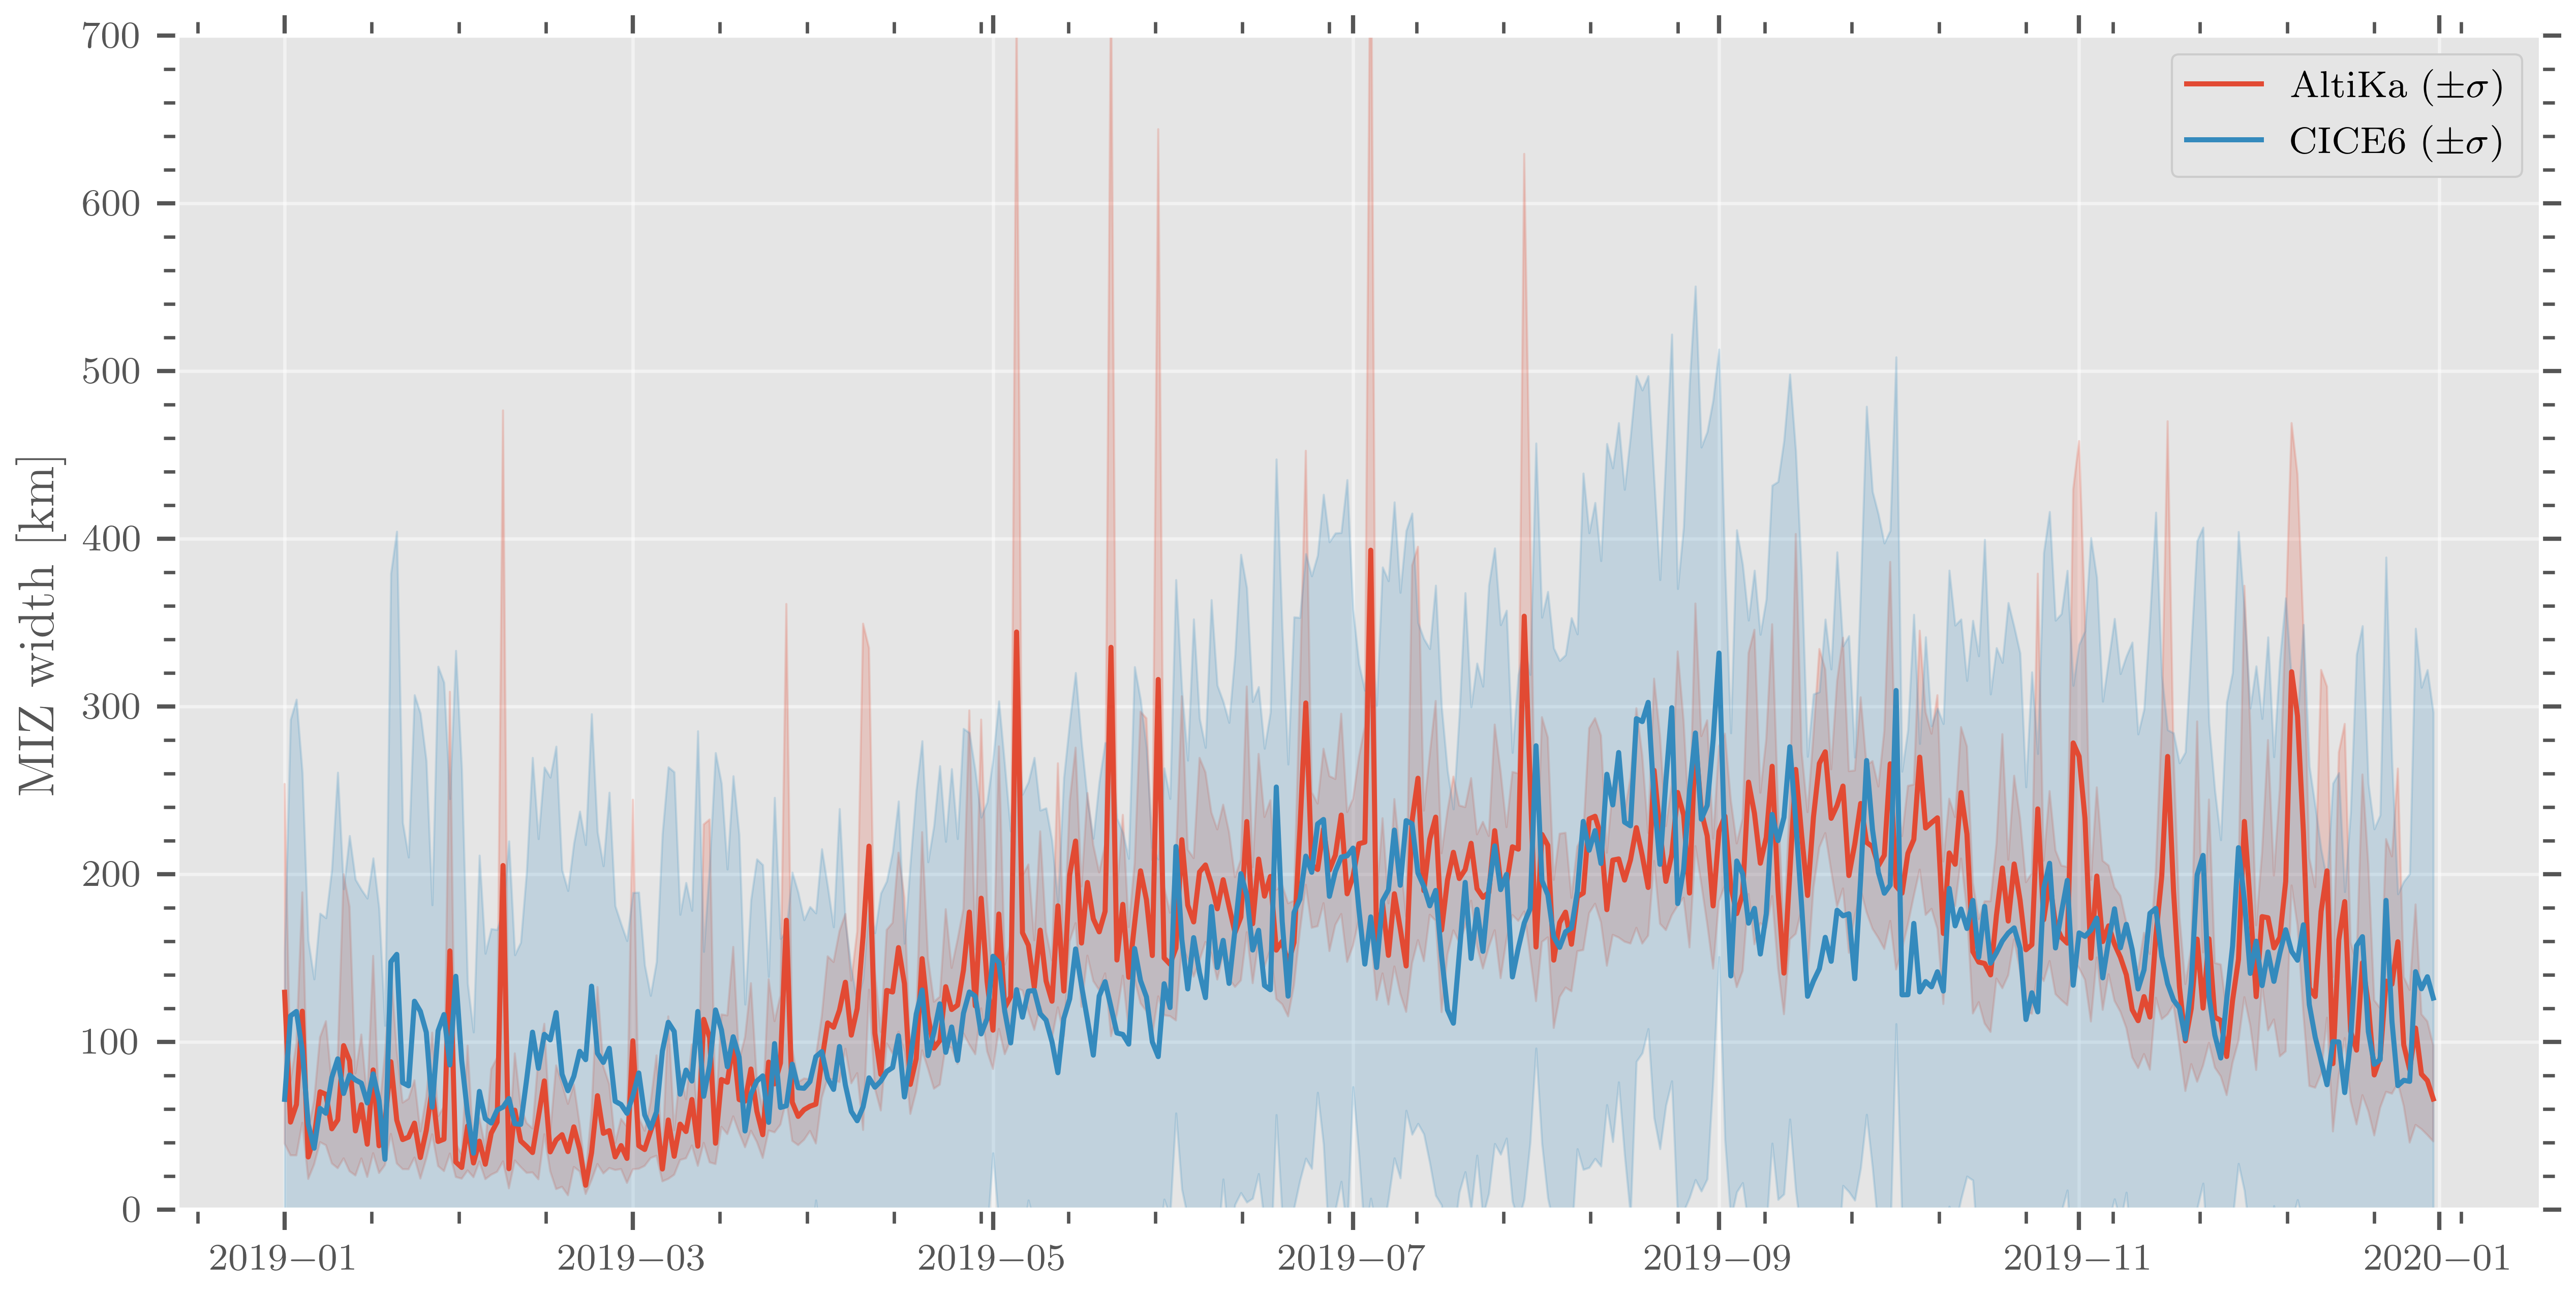

In [11]:
plt.style.use('ggplot')
rc('text', usetex=True)
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
sns.lineplot(ax=ax, x = pd.to_datetime(df['date'].dt.strftime('%Y-%m-%d')), y = df["mizWidthAlongTrackFromAltikaEdge"], 
             label = 'AltiKa ($\pm \sigma$)')
sns.lineplot(ax=ax, x = np.tile(pd.to_datetime(dates),(n_lon,1)).reshape(-1), y = np.transpose(np.asarray(data_xr)).reshape(-1) , 
             label = 'CICE6 ($\pm \sigma$)', errorbar='sd')

#sns.lineplot(ax=ax, x = pd.to_datetime(dates[9:]), y = data_xr.rolling(time=10, center=True).mean().dropna("time").mean(dim="ni") , label = 'CICE6 (10-day M.A.)')
ax.set(ylabel='MIZ width [km]',ylim=(0,700), xlabel = '')
savepath = '/home/566/nd0349/notebooks/figures/'
plt.savefig(savepath+'MIZ-width-AltiKa-1deg_2019_CICE_' + str(year) + '.png', dpi = 1000) 

In [ ]:
# Plot MIZ width timeseries
rc('text', usetex=False)

fig = plt.figure(figsize=(5,3))
ax = fig.add_subplot()
#.plot()
#df.groupby(df['date'].dt.date)["mizWidthAlongTrackFromMyEdge"].mean().plot(kind="line",rot=1)
sns.lineplot(ax=ax, x = df['date'].dt.strftime('%Y-%m-%d'), y = df["mizWidthAlongTrackFromAltikaEdge"], label = 'AltiKa')

#sns.lineplot(ax=ax, x = dates[0:-1], y = df.groupby(['month','day'],as_index=False).mean()["mizWidthAlongTrackFromMyEdge"], label = 'AltiKa')
sns.lineplot(ax=ax, x = dates, y = data_xr, label = 'CICE6-WIM')
ax.set(ylabel='MIZ width [km]', ylim = (0,275))

In [ ]:
cmap = cmo.haline
cmap.set_under = 'white'
#cmap
#cmap.under
cmap

#cmap.set_over('white',0.)
cmo.haline(range(256))

## Maps comparing MIZ widths for a month

/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1781: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  result = super().pcolormesh(*args, **kwargs)
/home/566/nd0349/.local/lib/python3.9/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/566/nd0349/.local/lib/python3.9/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: No contour levels were found within the data range.
  result = super().contour(*args, **kwargs)
100%|██████████| 500/500 [00:00<00:00, 607.43it/s]


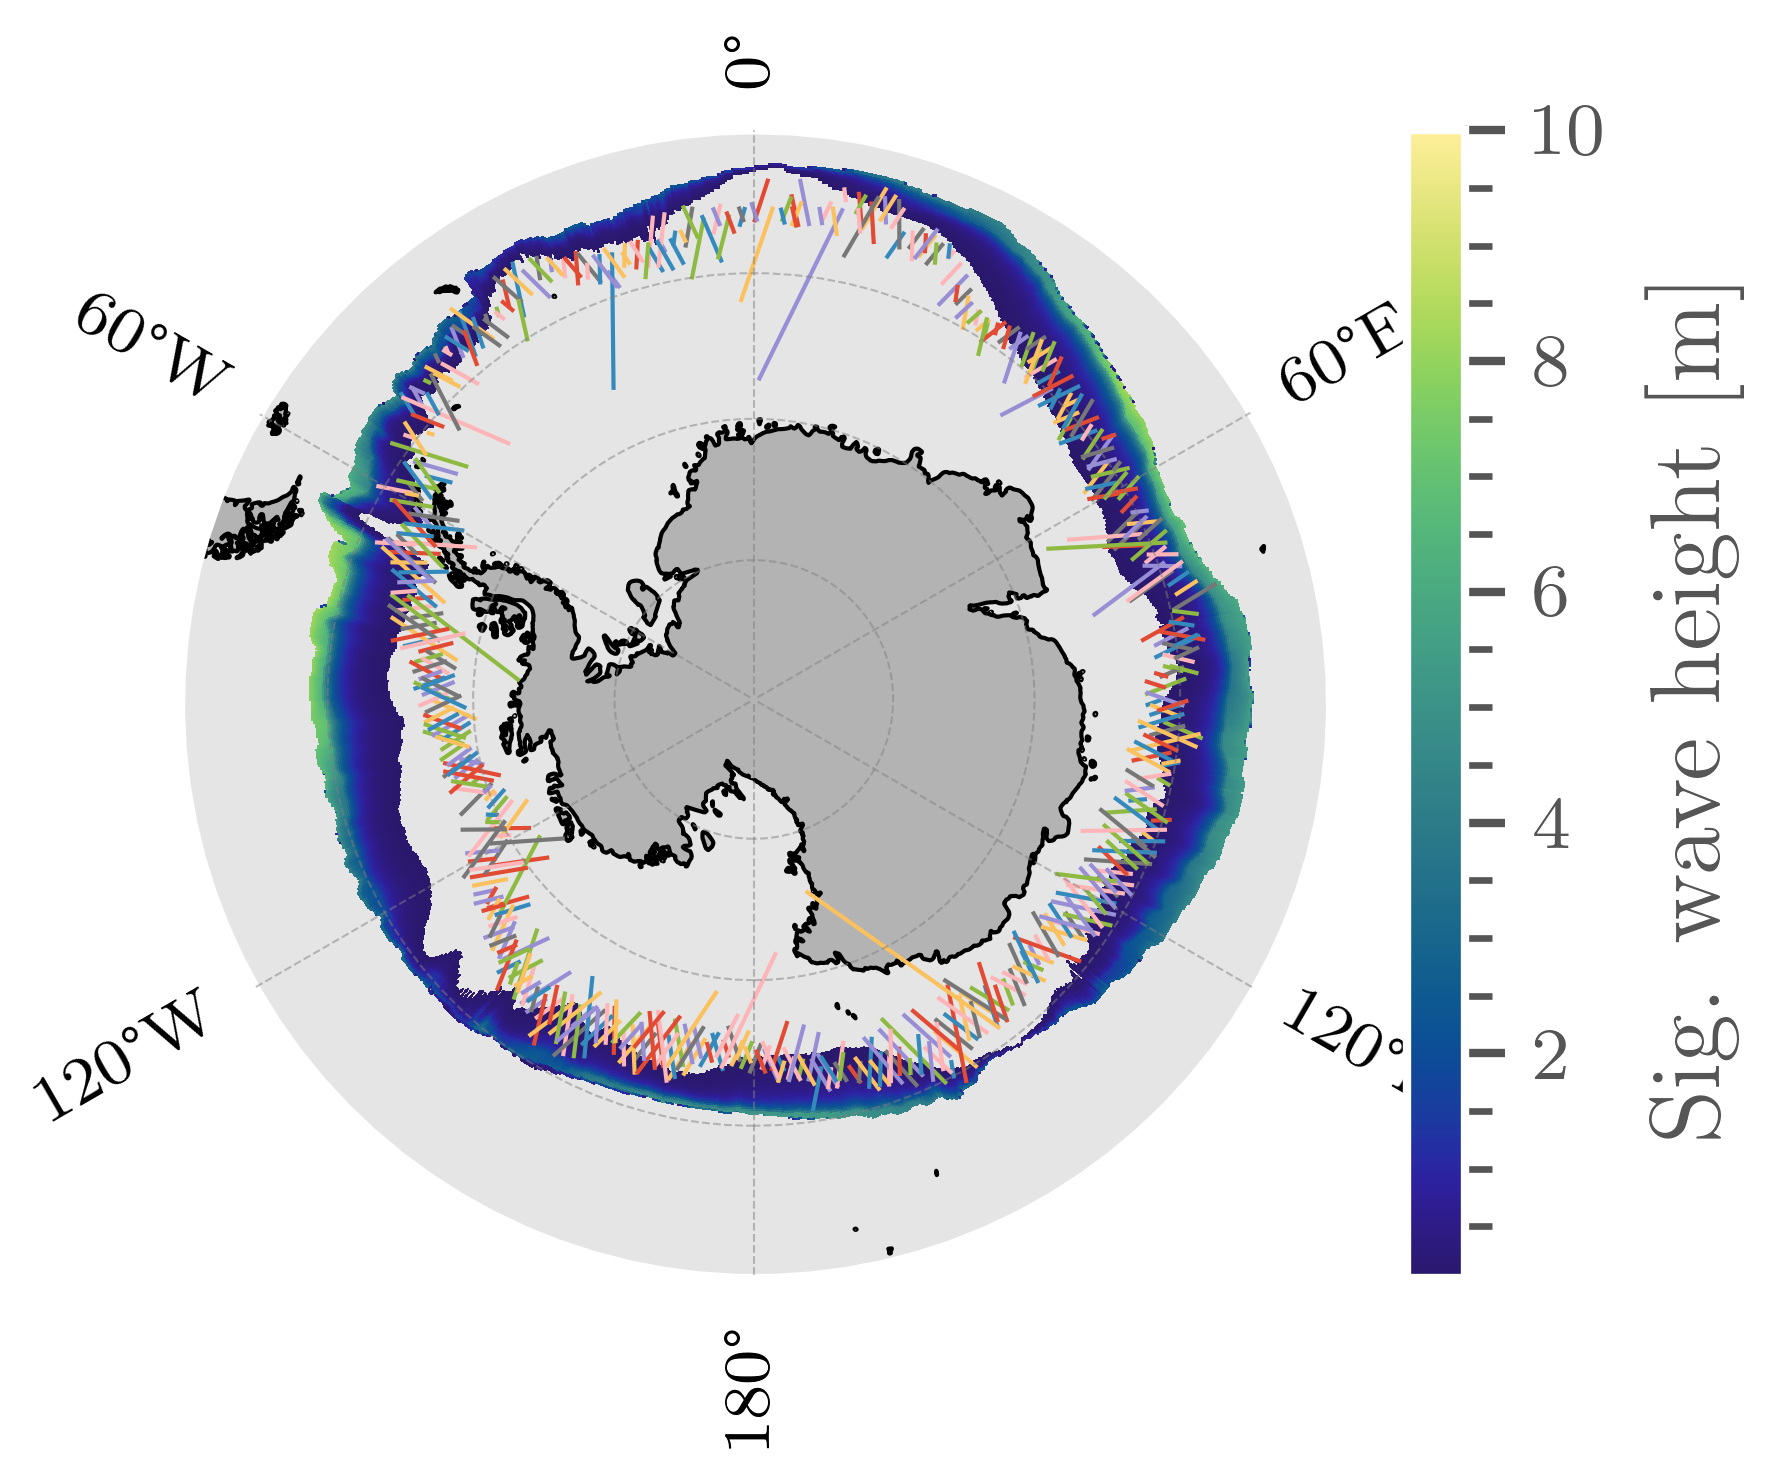

In [12]:
# Create a date vector to plot time series
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from datetime import datetime, timedelta


year = 2015
rc('text', usetex=True)
filename = '/g/data/ia40/cice-dirs/runs/waves-025/history/iceh.' + str(year) + '-09-01.nc'
ds = xr.open_dataset(filename)
LT = ds['TLAT']
LN = ds['TLON']
land_mask = ds['tmask'].where(ds['tmask'][:,:] != 1.) 
#del ds

fig = plt.figure(figsize=[width/2, height/2])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
ax = create_map_axis(ax=ax, LN=LN, LT=LT, land_mask=land_mask, draw_labels="all")
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())

# ax = fig.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo())
# ax.set_global()
# ax.coastlines('110m', alpha=0.1)
# coord_lims = [-180, 180, -90, -50]
# ax.set_extent(coord_lims, ccrs.PlateCarree())
    

#df = pd.read_csv(csv_file) 
month = 9
df = pd.read_csv('/g/data/ia40/miz-width/v0_6/2019' + ("%02d" % (month,)) + '_output_v0_6.csv')
timesteps,cols = df.shape
timesteps

cmap = cmo.haline
cmap = mpl.colors.ListedColormap(cmo.haline(range(256)))
cmap.set_bad('white',0.)
cmap.set_over('white',0.)
cmap.set_under('white',0.)
norm = mpl.colors.Normalize(vmin=0.05, vmax=10)
#norm = plt.Normalize(vmin=np.min(track_names), vmax=np.max(track_names))
plot_data = ds['wave_sig_ht'][0,:,:]
#plot_data = plot_data.where(ds['aice'][0,:,:]>0.15, drop=True)

p = ax.pcolormesh(LN, LT, plot_data,
            transform=ccrs.PlateCarree(),
            cmap=cmap,
            norm=norm,
#            vmin=1, vmax=1000,
            #norm=colors.LogNorm(vmin=1, vmax=1000),
            vmin=0.05, vmax=10,
            shading='auto')

# plot contour using each part of the 2 masked data sets
import numpy.ma as ma
LN_greater = ma.masked_greater(LN, -0.01)
LN_lesser = ma.masked_less(LN, 0)
LT_greater = ma.MaskedArray(LT, mask=LN_greater.mask)
LT_lesser = ma.MaskedArray(LT, mask=LN_lesser.mask)
aice_greater = ma.MaskedArray(ds['aice'][0,:,:], mask=LN_greater.mask)
aice_lesser = ma.MaskedArray(ds['aice'][0,:,:], mask=LN_lesser.mask)
levels = [0.15, 0.8]
vmax, vmin = 0, 1
cmap1 = "viridis"

norm1 = colors.BoundaryNorm(boundaries=levels, ncolors=16)
norm2 = colors.Normalize(vmin=vmin, vmax=vmax/4)
ct1 = ax.contour(LN_greater, LT_greater, aice_greater, 
                 norm=norm1, 
                 colors='k',
                 levels=levels, 
                 linewidths=0.5,
                 transform=ccrs.PlateCarree())

# ct2 = ax.contour(LN_lesser, LT_lesser, aice_lesser, 
#                  #norm=norm2, 
#                  colors='k',
#                  levels=levels, 
#                  linewidths=0.5,
#                  transform=ccrs.PlateCarree())


cbar = ax.figure.colorbar(p, ax=ax,
                         label='Sig. wave height [m]')

# Use the line contours to place contour labels.
# ax.clabel(
#     line_c,  # Typically best results when labelling line contours.
#     colors=['black'],
#     manual=False,  # Automatic placement vs manual placement.
#     inline=True,  # Cut the line where the label will be placed.
#     fmt=' {:.0f} '.format,  # Labels as integers, with some extra space.
# )
    
for i in tqdm(range(500)):
    date = df['first_meas_time'][i]
    x = [df["lonAtMyEdge"][i], df["lonAtInnerMIZ"][i]]
    y = [df["latAtMyEdge"][i], df["latAtInnerMIZ"][i]]
    plt.plot(x, y, transform=ccrs.Geodetic(), linestyle ='-', linewidth=0.5)#, color=cmap(norm(track_number)))
    # Add start date
    #plt.text(x[0], y[0], dates[0].strftime('%d-%m-%Y'), fontsize=2, transform=ccrs.Geodetic())



del ds
savepath = '/home/566/nd0349/notebooks/figures/'
plt.savefig(savepath+'Wave-pen-maps-AltiKa-Sep' + str(year) + '.png', dpi = 1000) 

## Histogram of MIZ widths in one month

In [47]:
month = 9
df = pd.read_csv('/g/data/ia40/miz-width/v0_6/2019' + ("%02d" % (month,)) + '_output_v0_6.csv')
timesteps,cols = df.shape
timesteps
df

# Read in CICE-WIM wave penetration
year = 2015
readfilename =  '/g/data/ia40/miz-width/wave-pen-'+str(year)+'_5cm_025deg.nc'
cice_wave_pen = xr.open_dataset(readfilename)
data_xr = xr.DataArray(cice_wave_pen.wave_penetration[0:365,:]/1000, dims=["time", "ni"])
n_day,n_lon = data_xr.shape

dates = pd.date_range(start="2019-01-01",end="2019-12-31", freq='d')
#np.tile(pd.to_datetime(dates[0:n_day]),(n_lon,1)).reshape(-1).shape
#np.transpose(np.asarray(data_xr)).reshape(-1).shape


In [128]:
#df_altika.groupby('date')
#pd.to_datetime(df["first_meas_time"]).strftime('%Y-%m-%d')



DatetimeIndex(['2019-09-01 00:26:31.891037', '2019-09-01 01:16:50.559968',
               '2019-09-01 02:07:08.880244', '2019-09-01 02:57:27.524435',
               '2019-09-01 03:47:45.835492', '2019-09-01 04:38:04.433297',
               '2019-09-01 05:28:22.952726', '2019-09-01 06:18:41.292359',
               '2019-09-01 07:08:59.566002', '2019-09-01 07:59:18.128457',
               ...
               '2019-09-30 16:17:49.146698', '2019-09-30 17:08:07.439663',
               '2019-09-30 17:58:26.037551', '2019-09-30 18:48:44.345537',
               '2019-09-30 19:39:02.918553', '2019-09-30 20:29:21.204715',
               '2019-09-30 21:19:39.761436', '2019-09-30 22:09:58.130696',
               '2019-09-30 23:00:16.682940', '2019-09-30 23:50:35.136343'],
              dtype='datetime64[ns]', length=817, freq=None)

In [48]:


df_altika  = pd.DataFrame({"date": pd.to_datetime(df["first_meas_time"].values, format='%Y-%m-%d').strftime('%Y-%m-%d').values,
                        "miz_width": df["mizWidthAlongTrackFromAltikaEdge"].values,
                             })
df_cice  = pd.DataFrame({"date": pd.to_datetime(np.tile(pd.to_datetime(dates),(n_lon,1)).reshape(-1)).strftime('%Y-%m-%d').values, 
                        "miz_width": np.transpose(np.asarray(data_xr)).reshape(-1),
                             })
mask = (df_cice['date'] >= '2019-09-01') & (df_cice['date'] < '2019-10-01')
df_cice = df_cice.loc[mask]

mask = (df_cice['miz_width'] > 0.0)
df_cice = df_cice.loc[mask]
df_cice

date    miz_width
243     2019-09-01   519.425423
244     2019-09-02  1054.469657
245     2019-09-03   256.788416
246     2019-09-04   428.569386
247     2019-09-05    77.189755
...            ...          ...
525503  2019-09-26   199.248776
525504  2019-09-27    31.269197
525505  2019-09-28   487.724017
525506  2019-09-29    93.470364
525507  2019-09-30    31.495258

[31828 rows x 2 columns]

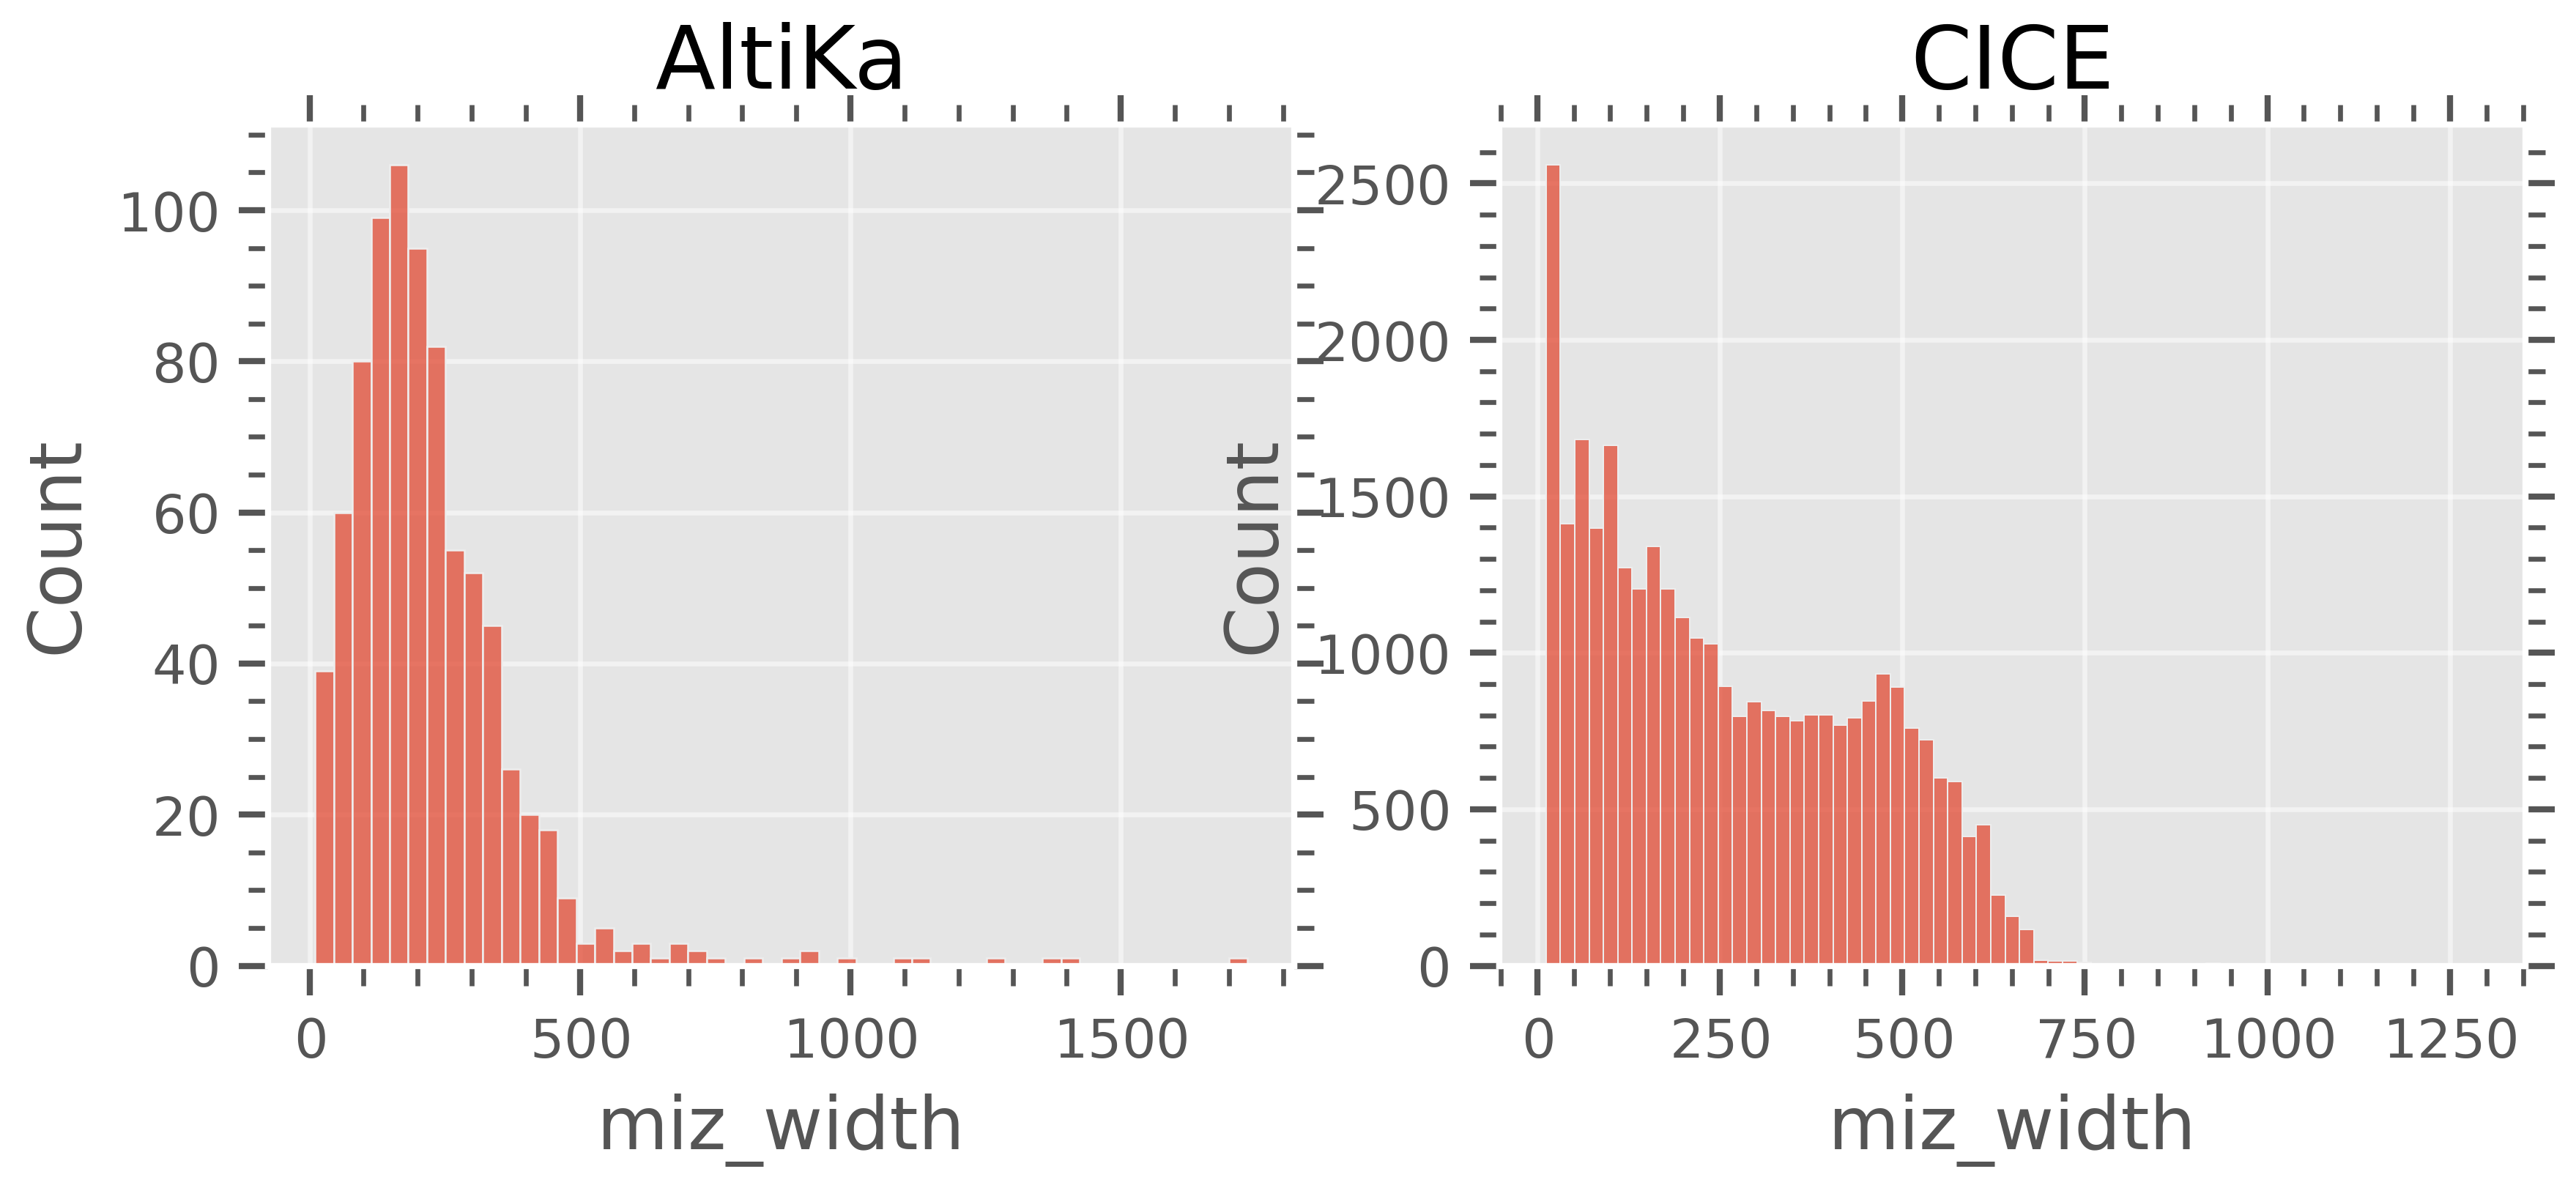

In [38]:
fig, axes = plt.subplots(1, 2, figsize=(width,height/2), sharex=False)
ax1 = axes[0]
ax2 = axes[1]


rc('text', usetex=False)
sns.histplot(ax = ax1, data=df_altika, x="miz_width")
sns.histplot(ax = ax2, data=df_cice, x="miz_width")

ax1.set_title('AltiKa')
ax2.set_title('CICE')


savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'histogram_sep' + str(year) + '.png', dpi = 300)  
plt.show()
# # Get the FSD processes into a plotting dataframe
# df_grouped = df_fsd[["dafsd_wave", "dafsd_weld", "dafsd_newi", "dafsd_latm", "dafsd_latg", "k"]].groupby('k').mean(numeric_only=True)
# df_grouped["dafsd_latm"] = df_grouped["dafsd_latm"]*100#.values*(10^5)
# df_grouped["dafsd_latg"] = df_grouped["dafsd_latg"]*10000
# # , "dafsd_latm", "dafsd_latg"
# xtick_labels_fsd = ['Wave breakup', 'Welding', 'New floe\nformation', 'Lateral melt\n($10^{-2}$)', 'Lateral\ngrowth ($10^{-4}$)']
# df_plot_fsd = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
#                         '2': df_grouped.iloc[1,:].values,
#                         '3': df_grouped.iloc[2,:].values},
#                         index=xtick_labels_fsd)


# # Get the melting processes into a plotting dataframe
# df_melt = pd.DataFrame({'k': df["k"].values,
#                              "date": df["date"].values,
#                              "meltt": df["meltt"].values*10,
#                              "meltl": df["meltl"].values,
#                              "meltb": df["meltb"].values,
#                             })
# df_grouped = df_melt[["meltb", "meltl", "meltt", "k"]].groupby('k').mean(numeric_only=True)
# df_plot_melt = pd.DataFrame({'1': df_grouped.iloc[0,:].values,
#                         '2': df_grouped.iloc[1,:].values,
#                         '3': df_grouped.iloc[2,:].values},
#                         index=['Basal melt', 'Lateral melt', 'Top melt'])


#df_plot.plot(ax = ax1, kind='bar', stacked=False, 
#             #color=[(0.9805, 0.5000, 0.4453, 1.0), (0.4416, 0.7490, 0.4322, 1.0), (0.3639, 0.5755, 0.748, 1.0)],
#             )

## Scatter of MIZ widths in one month

In [156]:
df_cice['date']

243      2019-09-01
244      2019-09-02
245      2019-09-03
246      2019-09-04
248      2019-09-06
            ...    
525503   2019-09-26
525505   2019-09-28
525506   2019-09-29
525507   2019-09-30
525508   2019-10-01
Name: date, Length: 33992, dtype: datetime64[ns]

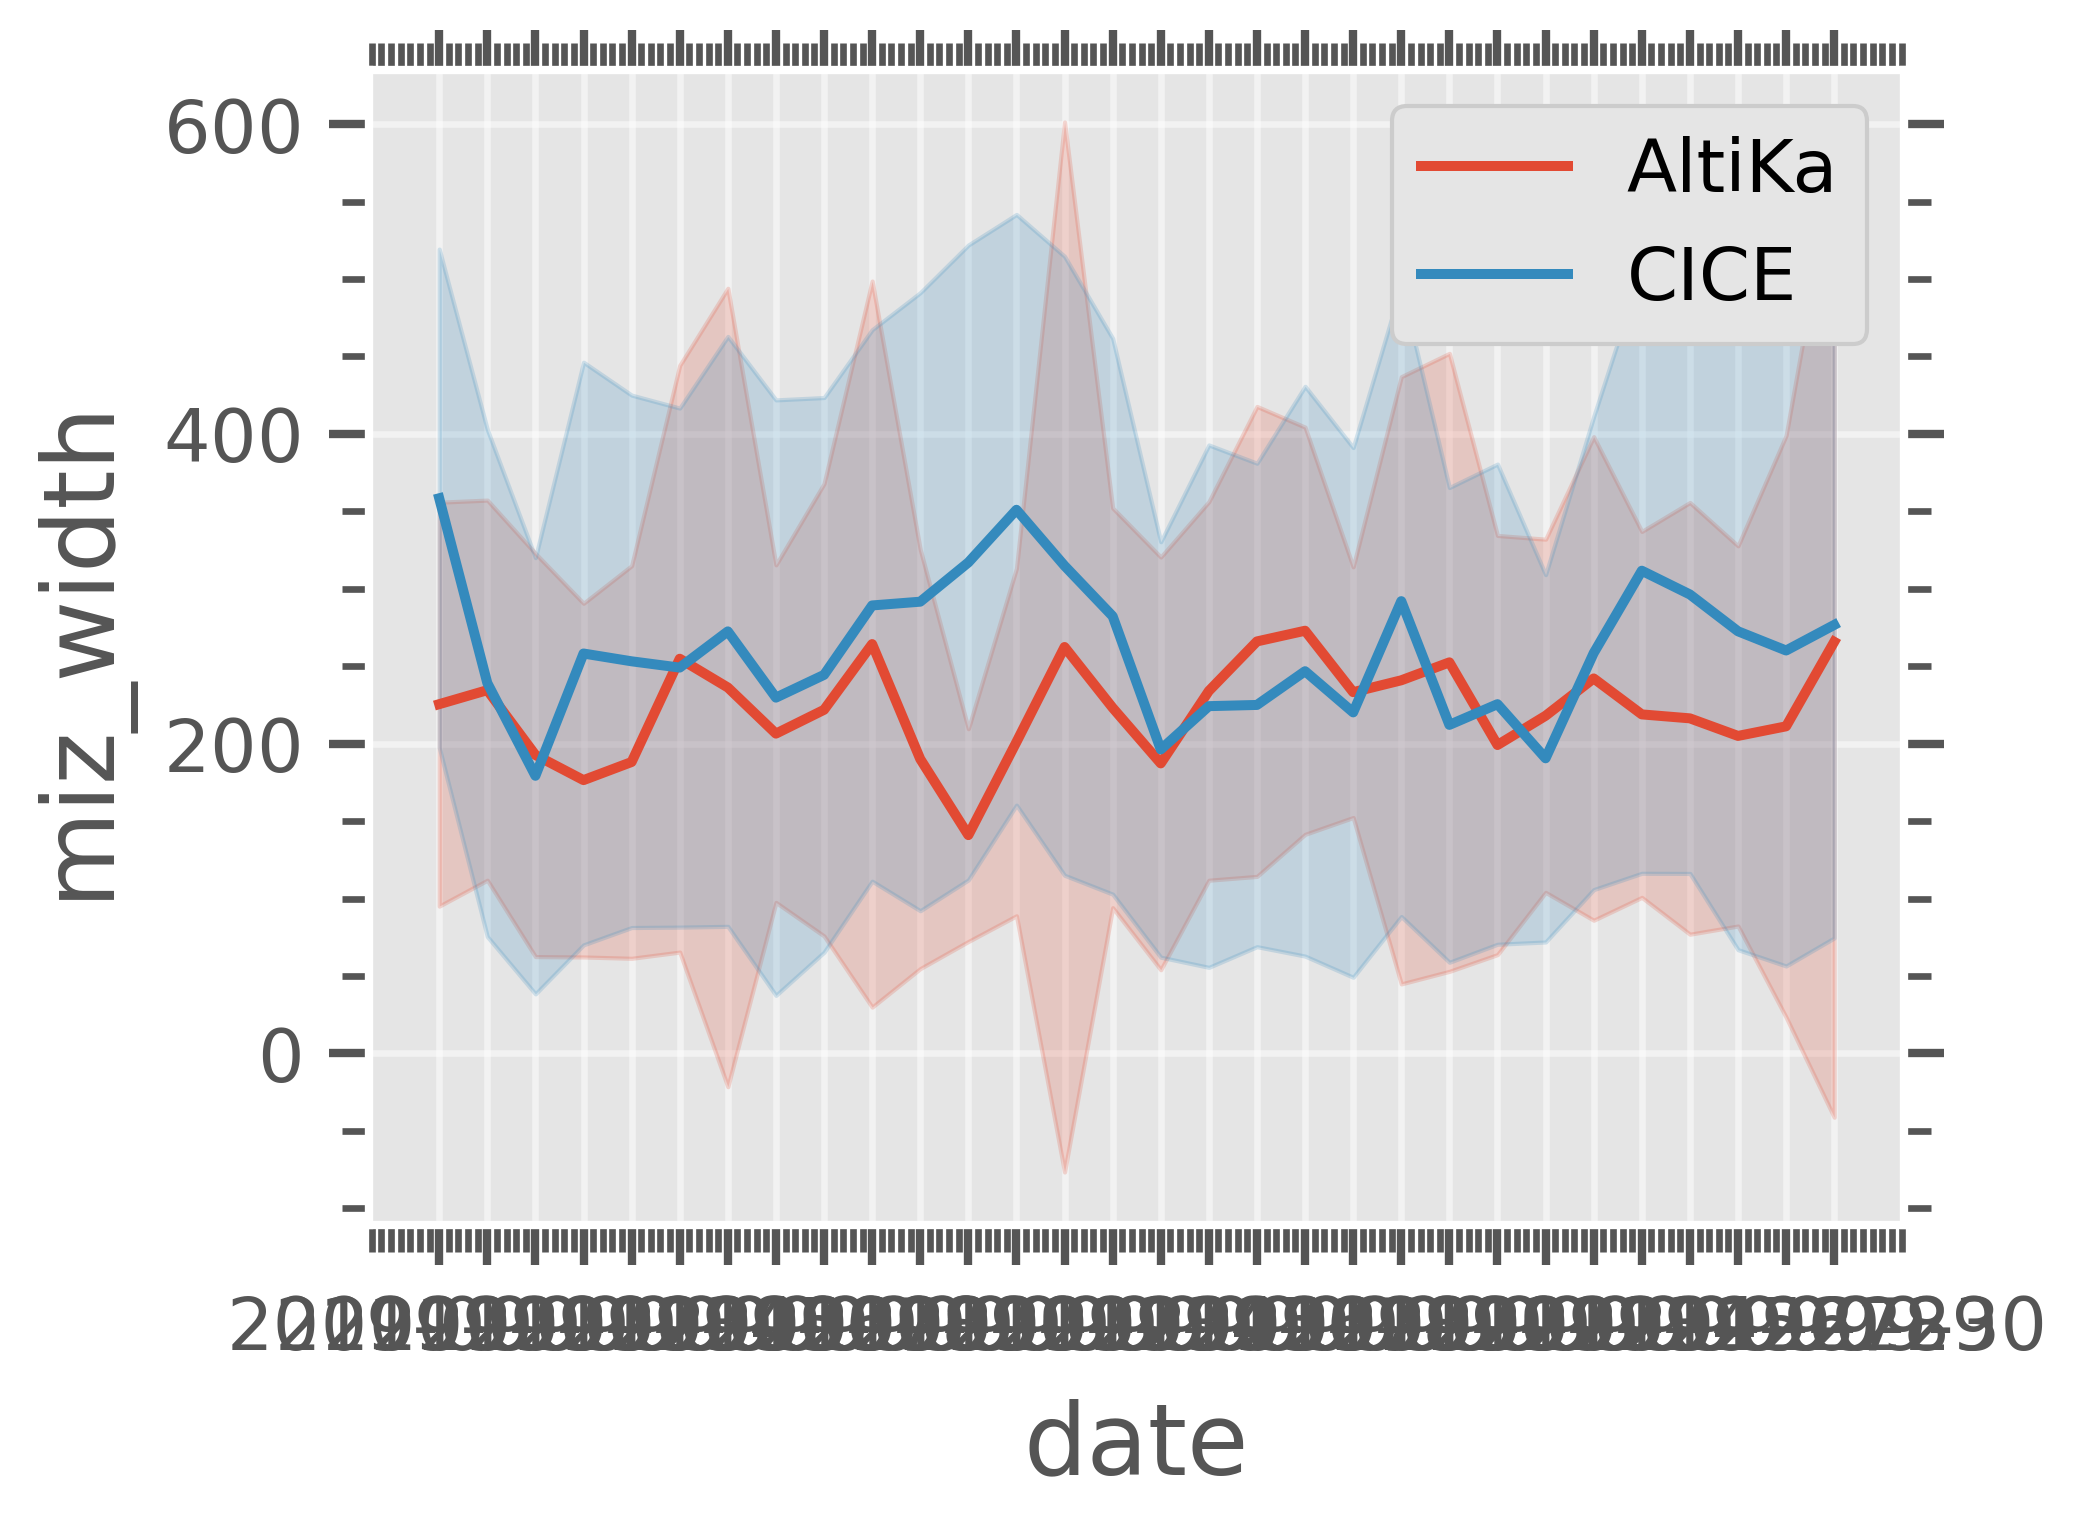

In [57]:
rc('text', usetex=False)
ax = sns.lineplot(x = df_altika['date'], 
                 y = df_altika['miz_width'],
                  errorbar = ("sd", 1),
                   label = "AltiKa"
            )
sns.lineplot(x = df_cice['date'], 
              y = df_cice['miz_width'],
             errorbar = ("sd", 1),
             label = "CICE"
             )
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'MIZ_width_just_Sep_' + str(year) + '.png', dpi = 300)  
plt.show()

In [168]:
#df_cice.groupby('date')['miz_width'].mean().plot()
#df_altika.groupby('date')['miz_width'].mean().plot()
df_cice.groupby('date')['miz_width'].mean().shape
df_altika.groupby('date')['miz_width'].mean().shape
df_cice.groupby('date').min()

miz_width
date                 
2019-09-01  12.497922
2019-09-02  12.743241
2019-09-03  12.497922
2019-09-04  12.595626
2019-09-05  12.546703
2019-09-06  12.352430
2019-09-07  12.256146
2019-09-08  12.304217
2019-09-09  12.497922
2019-09-10  12.497922
2019-09-11  12.497922
2019-09-12  12.449283
2019-09-13  12.546703
2019-09-14  12.595626
2019-09-15  12.595626
2019-09-16  12.497922
2019-09-17  12.546703
2019-09-18  12.546703
2019-09-19  12.497922
2019-09-20  12.546703
2019-09-21  12.546703
2019-09-22  12.497922
2019-09-23  12.792728
2019-09-24  12.449283
2019-09-25  12.743241
2019-09-26  12.449283
2019-09-27  12.304217
2019-09-28  12.208218
2019-09-29  12.304217
2019-09-30  12.256146

<function matplotlib.pyplot.show(close=None, block=None)>

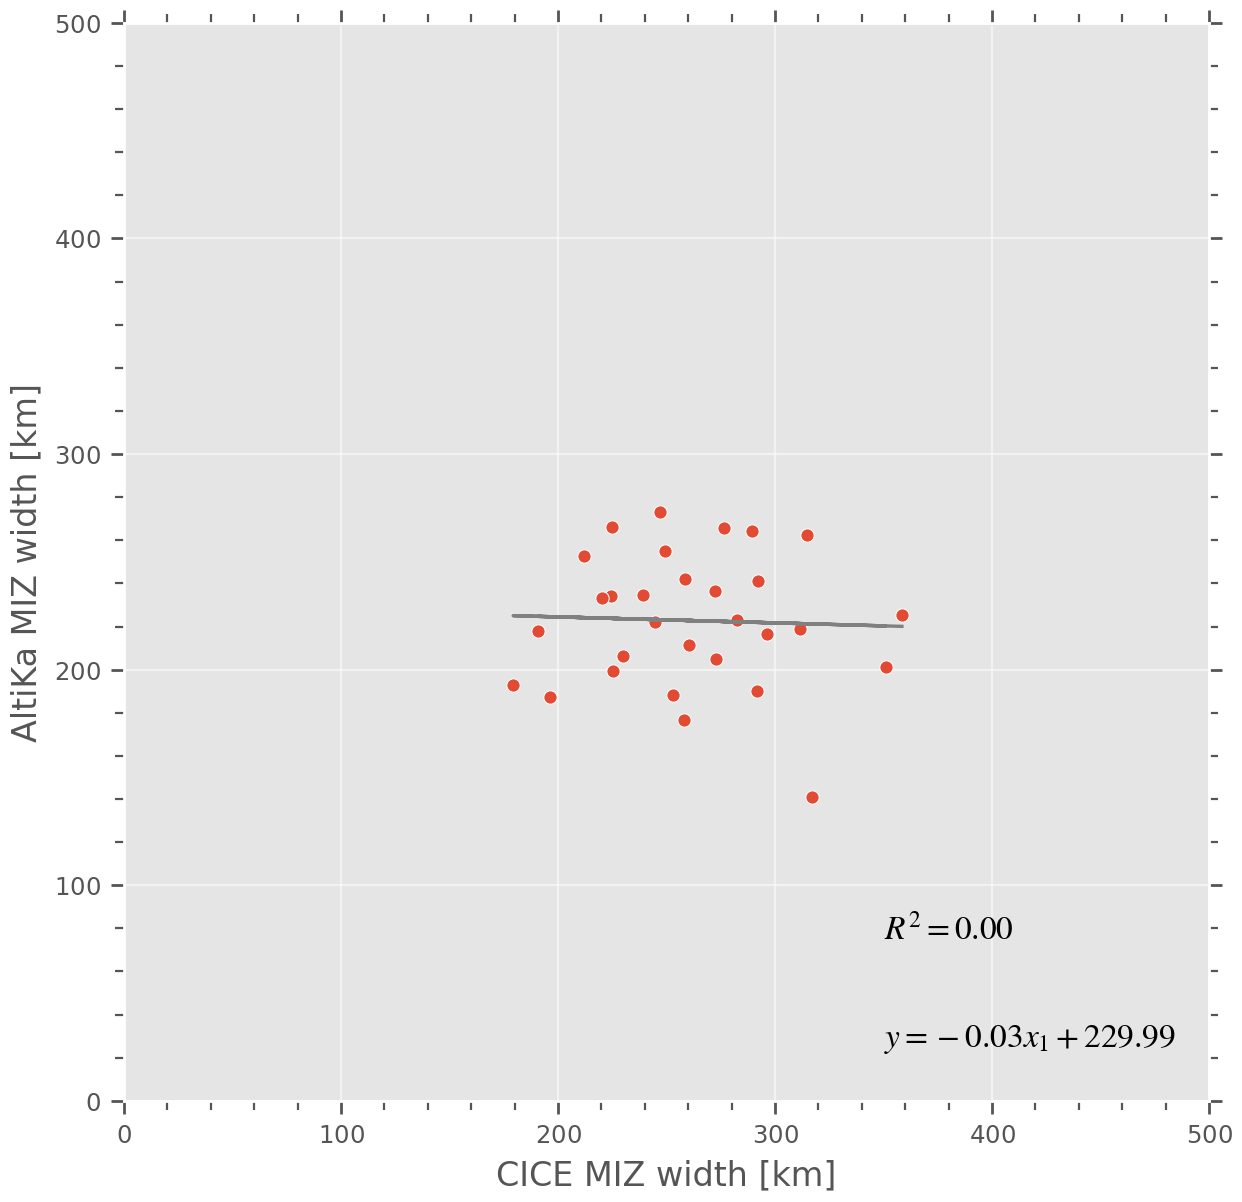

In [49]:
from scipy import stats
from sklearn import linear_model

# Linear regression
x = df_cice.groupby('date')['miz_width'].mean()
y = df_altika.groupby('date')['miz_width'].mean()
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

#fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
#density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)


plt.figure(figsize = (7,7), dpi = 200)
ax = sns.scatterplot(x = df_cice.groupby('date')['miz_width'].mean(), 
              y = df_altika.groupby('date')['miz_width'].mean())
ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')

ax.set(ylim = (0,500), xlim = (0, 500),
      xlabel = 'CICE MIZ width [km]', ylabel = 'AltiKa MIZ width [km]')
ax.text(0.70, 0.15, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
ax.text(0.70, 0.05, '$y = %.2f x_1 + %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'linear_regression_sep_2019_vs_sep_' + str(year) + '.png', dpi = 300)  
plt.show

## Scatter across the whole year

Reading in Alex's data: 100%|██████████| 12/12 [00:00<00:00, 101.67it/s]


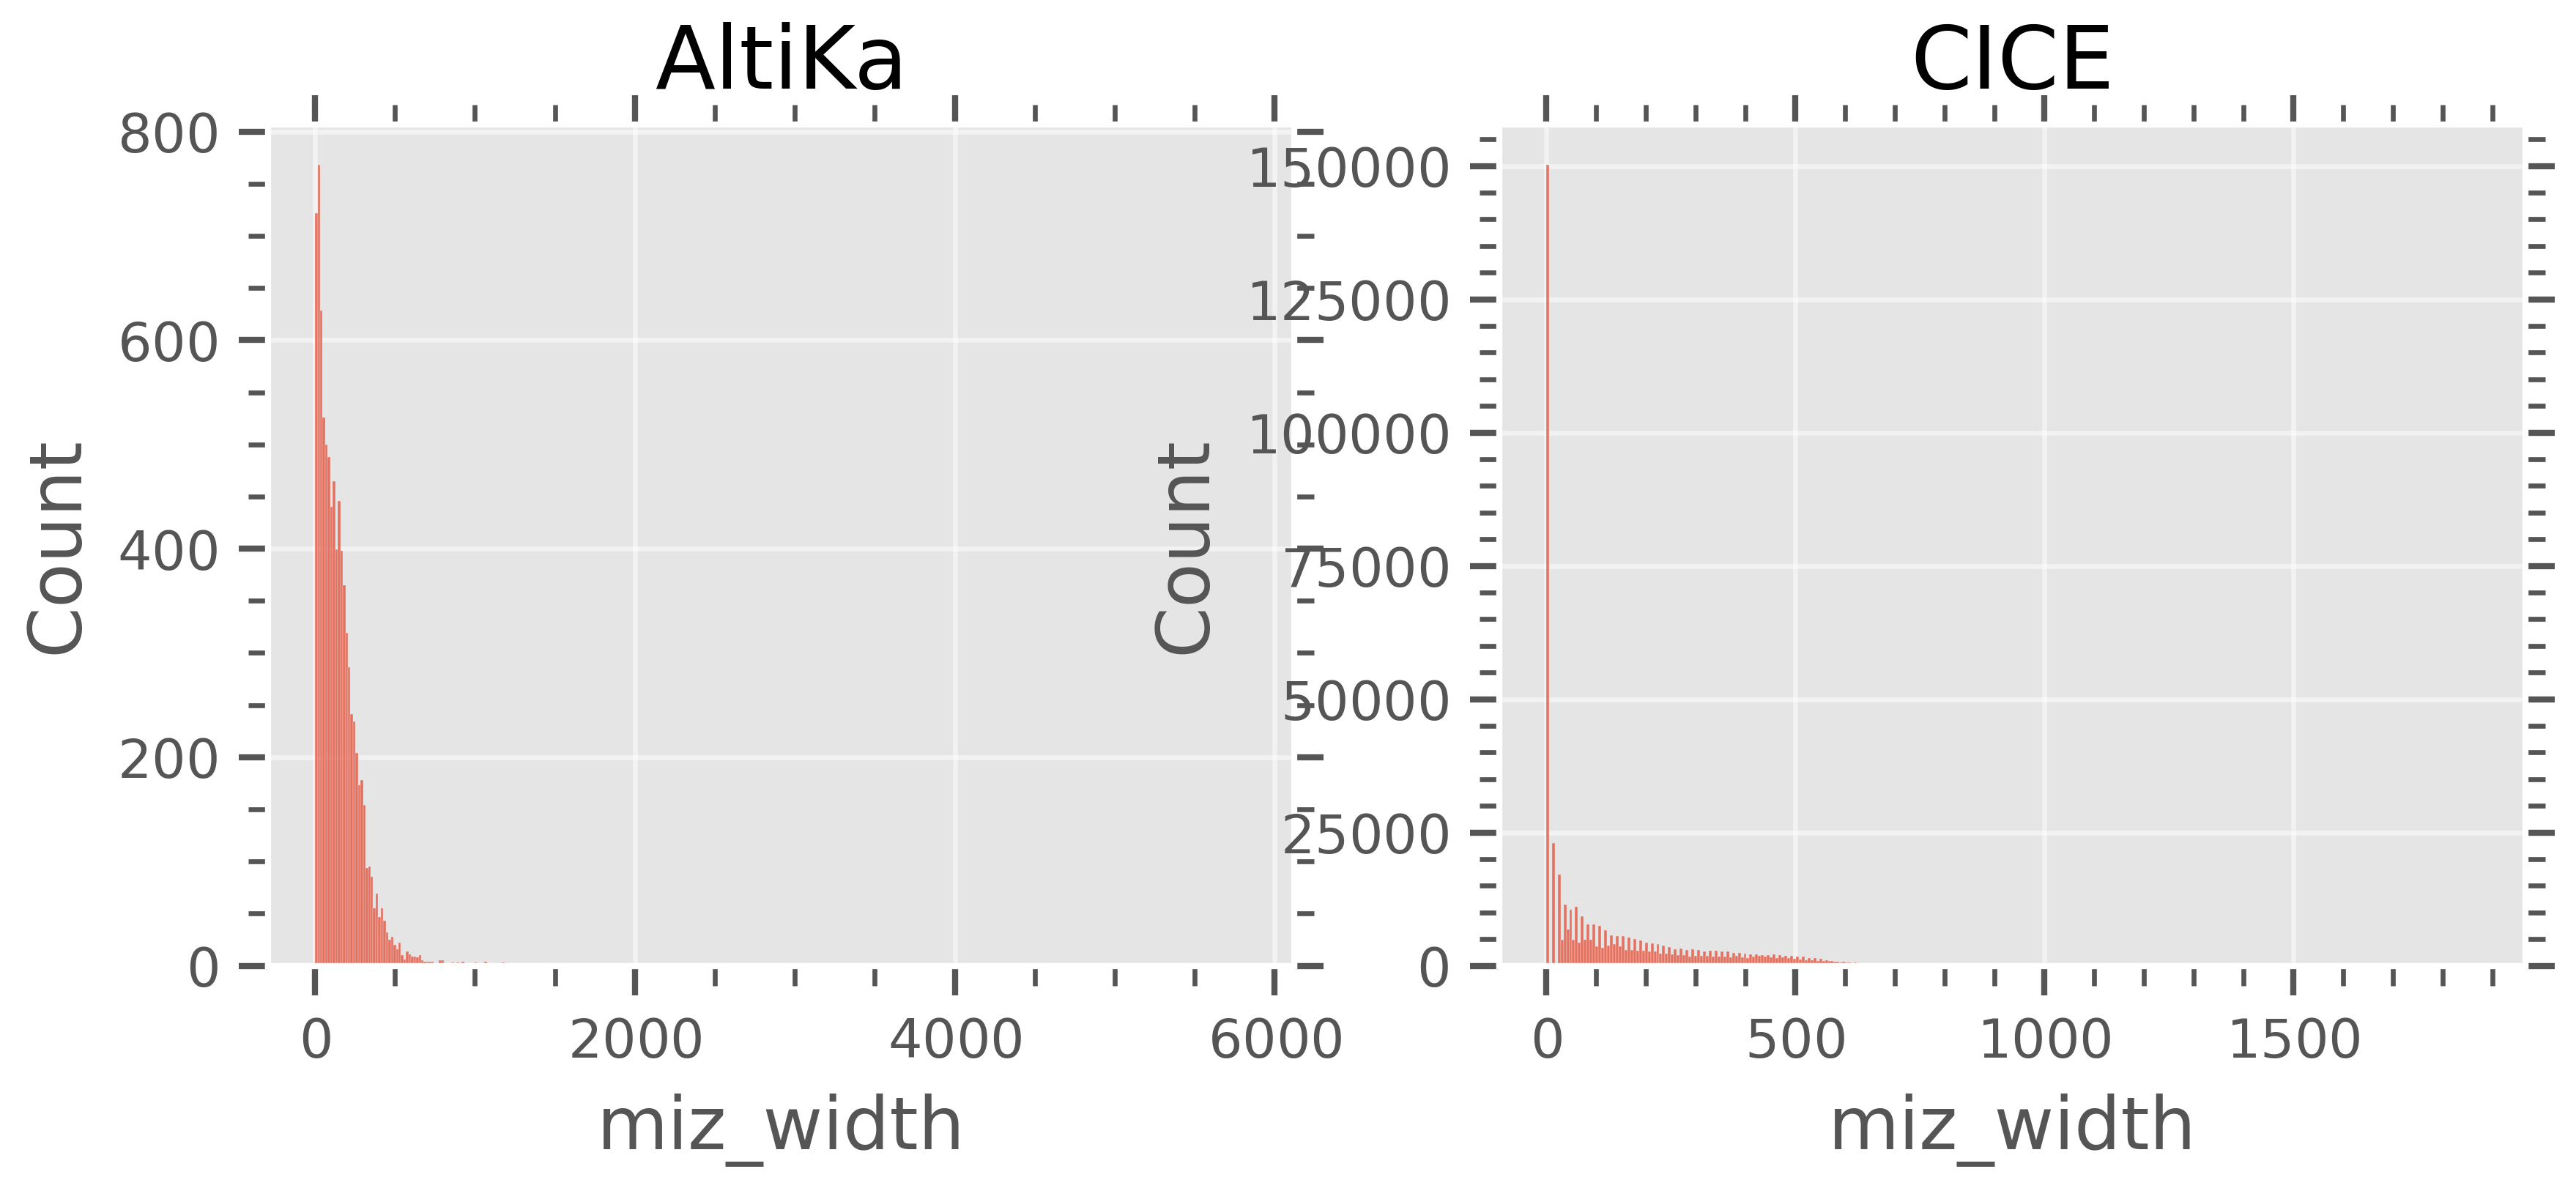

In [40]:
month_range = range(1,13)
df = pd.concat((pd.read_csv('/g/data/ia40/miz-width/v0_6/2019' + ("%02d" % (month,)) + '_output_v0_6.csv') 
                for month in tqdm(month_range, total = len(month_range), desc = "Reading in Alex's data")),
                ignore_index=True)

df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
df.head(5)

# Read in CICE-WIM wave penetration
year = 2015
readfilename =  '/g/data/ia40/miz-width/wave-pen-'+str(year)+'_5cm_025deg.nc'
cice_wave_pen = xr.open_dataset(readfilename)
data_xr = xr.DataArray(cice_wave_pen.wave_penetration[0:365,:]/1000, dims=["time", "ni"])
n_day,n_lon = data_xr.shape

dates = pd.date_range(start="2019-01-01",end="2019-12-31", freq='d')


df_altika  = pd.DataFrame({"date": pd.to_datetime(df["first_meas_time"].values, format='%Y-%m-%d').strftime('%Y-%m-%d').values,
                        "miz_width": df["mizWidthAlongTrackFromAltikaEdge"].values,
                             })
df_cice  = pd.DataFrame({"date": pd.to_datetime(np.tile(pd.to_datetime(dates),(n_lon,1)).reshape(-1)).strftime('%Y-%m-%d').values, 
                        "miz_width": np.transpose(np.asarray(data_xr)).reshape(-1),
                             })

fig, axes = plt.subplots(1, 2, figsize=(width,height/2), sharex=False)
ax1 = axes[0]
ax2 = axes[1]


rc('text', usetex=False)
sns.histplot(ax = ax1, data=df_altika, x="miz_width")
sns.histplot(ax = ax2, data=df_cice, x="miz_width")

ax1.set_title('AltiKa')
ax2.set_title('CICE')


savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'histogram_' + str(year) + '.png', dpi = 300)  
plt.show()

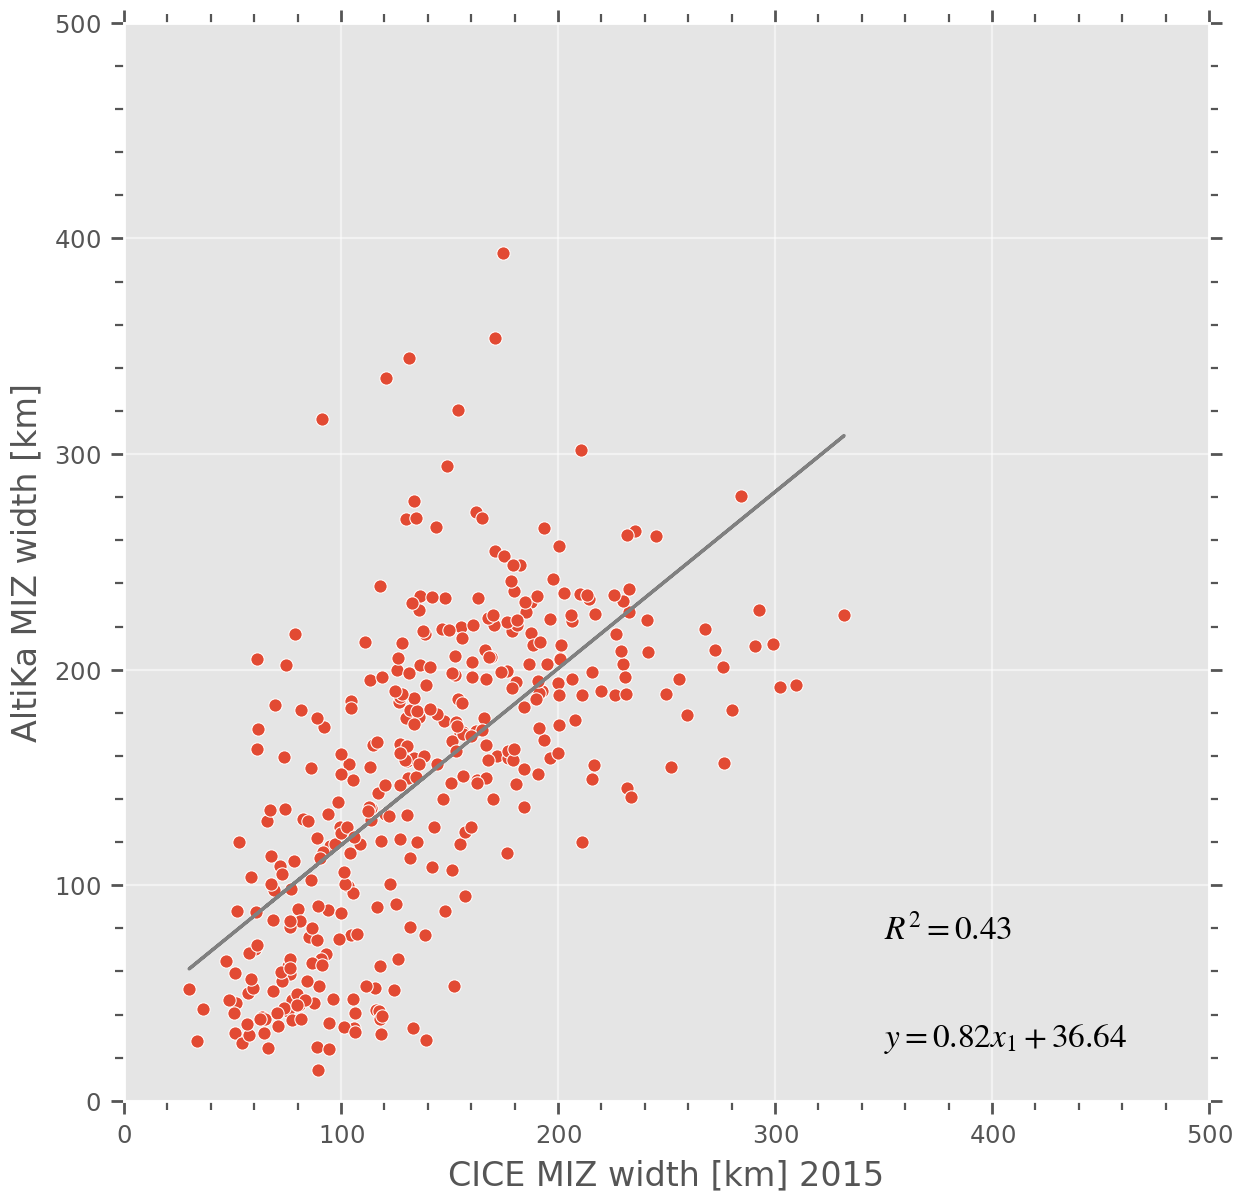

In [41]:
from scipy import stats
from sklearn import linear_model

# Linear regression
x = df_cice.groupby('date')['miz_width'].mean()[0:364]
y = df_altika.groupby('date')['miz_width'].mean()
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

#fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
#density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)


plt.figure(figsize = (7,7), dpi = 200)
ax = sns.scatterplot(x = df_cice.groupby('date')['miz_width'].mean(), 
              y = df_altika.groupby('date')['miz_width'].mean())
ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')

ax.set(ylim = (0,500), xlim = (0, 500),
      xlabel = 'CICE MIZ width [km] ' + str(year), ylabel = 'AltiKa MIZ width [km]')
ax.text(0.70, 0.15, '$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
ax.text(0.70, 0.05, '$y = %.2f x_1 + %.2f $' % (model.coef_[0], model.intercept_), fontsize=12, transform=ax.transAxes)


savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'linear_regression_2019_vs_' + str(year) + '.png', dpi = 300)  
plt.show()

In [187]:
df_cice.groupby('date')['miz_width'].mean()[0:364]
#df_altika.groupby('date')['miz_width'].mean()[0:365]

date
2019-01-01    84.279467
2019-01-02    63.547787
2019-01-03    57.581380
2019-01-04    45.140410
2019-01-05    55.933362
                ...    
2019-12-26    52.194768
2019-12-27    54.620588
2019-12-28    75.483997
2019-12-29    65.793681
2019-12-30    77.277841
Name: miz_width, Length: 364, dtype: float64

In [ ]:
# Make a density scatter plot
from scipy import stats
from sklearn import linear_model
#temp = wave_penetration_array[:,:].reshape(-1)
#temp_pen = wave_penetration_array[0:10,:]
#temp_swh = incident_swh_array[0:10,:]
temp_pen = wave_penetration_array[0:-1:1,:].reshape(-1)
temp_swh = incident_swh_array[0:-1:1,:].reshape(-1)

idx = np.logical_or(np.isnan(temp_pen),np.isnan(temp_swh))
idx = np.logical_or(idx, (np.abs(temp_pen)>100000000)) # make sure wave pen not inf
idx = np.logical_or(idx, (np.abs(temp_swh)<0.01)) # Ignore waves that are smaller than 1 cm
#idx = np.logical_or(idx, (temp_pen<0)) # make sure wave pen not inf
#idx = temp > 1.0
#plot_swh = incident_swh_array.reshape(-1)[idx]
#temp = wave_penetration_array[:,:].reshape(-1)
plot_swh = temp_swh[~idx]#.reshape(-1)
plot_wave_pen = temp_pen[~idx]#.reshape(-1)

x = plot_swh
y = plot_wave_pen/1000
print(x.shape)
# Calculate the point density
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x_kde, y_kde, z_kde = x[idx], y[idx], z[idx]

# Linear regression
ols = linear_model.LinearRegression()
model = ols.fit(np.asarray(x).reshape(-1, 1) , np.asarray(y).reshape(-1, 1) )
response = model.predict(np.asarray(x).reshape(-1, 1))
r2 = model.score(np.asarray(x).reshape(-1, 1), np.asarray(y).reshape(-1, 1))

plt.style.use("ggplot")

fig, ax = plt.subplots()
#fig = plt.figure()
#using_mpl_scatter_density(fig, x, y)
#scatter_density(x, y, cmap=white_viridis)
density = ax.scatter(x_kde, y_kde, c=z_kde, s=1)
#sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter=False)
ax.plot(x, response, label='Regression model', color='0.5', linestyle='-')
fig.colorbar(density, label='Probability density')
plt.xlabel("Significant wave height [m]")
plt.ylabel("Wave penetration [km]")
plt.xlim([0, 12])
ax.text(0.70, 0.15, '$R^2= %.2f$' % r2, fontsize=6, transform=ax.transAxes)
ax.text(0.70, 0.05, '$y = %.2f x_1 + %.2f $' % (model.coef_[0], model.intercept_), fontsize=6, transform=ax.transAxes)
#plt.ylim([0, 1000])
savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'wave-pen_vs_swh_5cm_2012_025deg.png', dpi = 300)  
plt.show()

In [ ]:
x, y, z = sample_data((20, 40))
z = z * -1.5 * y
LN.shape
LN.max()

# Hovmoller of MIZ widths

## Read in MIZ widths

In [23]:
year = 2015
readfilename =  '/g/data/ia40/miz-width/wave-pen-'+str(year)+'_5cm_025deg.nc'
cice_wave_pen = xr.open_dataset(readfilename)
data_xr = xr.DataArray(cice_wave_pen.wave_penetration[0:365,:]/1000, dims=["time", "ni"])
n_day,n_lon = data_xr.shape

dates = pd.date_range(start="2019-01-01",end="2019-12-31", freq='d')
np.tile(pd.to_datetime(dates[0:n_day]),(n_lon,1)).reshape(-1).shape
np.transpose(np.asarray(data_xr)).reshape(-1).shape

(525600,)

In [24]:
# Read in Alex's data
# csv_file = '/g/data/ia40/miz-width/may-nov-2019/201909_output_v0_5.csv'
# df = pd.read_csv(csv_file) 

# #df.drop(['B', 'C'], axis=1)
# df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
# df.head(5)

month_range = range(1,13)
df = pd.concat((pd.read_csv('/g/data/ia40/miz-width/v0_6/2019' + ("%02d" % (month,)) + '_output_v0_6.csv') 
                for month in tqdm(month_range, total = len(month_range), desc = "Reading in Alex's data")),
                ignore_index=True)

df = df[['first_meas_time', 'swhAtMyEdge', 'lonAtMyEdge', 'latAtMyEdge', 'lonAtAltiKaEdge','latAtAltiKaEdge', 'lonAtInnerMIZ', 'latAtInnerMIZ', 'mizWidthAlongTrackFromMyEdge', 'mizWidthAlongTrackFromAltikaEdge']]
df.head()

Reading in Alex's data: 100%|██████████| 12/12 [00:00<00:00, 102.76it/s]


first_meas_time  swhAtMyEdge  lonAtMyEdge  latAtMyEdge  \
0  2019-01-01 00:08:57.846325     1.620804   229.766361   -71.222940   
1  2019-01-01 01:49:34.787013     3.083900   206.868290   -69.771072   
2  2019-01-01 02:39:53.429413     0.607289    66.490548   -65.007824   
3  2019-01-01 03:30:11.661906     1.649591   184.496235   -67.638416   
4  2019-01-01 04:20:30.283893     2.221555    42.835584   -66.481168   

   lonAtAltiKaEdge  latAtAltiKaEdge  lonAtInnerMIZ  latAtInnerMIZ  \
0       228.563642       -71.910314     228.767186     -71.800393   
1       206.283788       -70.168697     204.696043     -71.171245   
2        66.809882       -65.337205      66.779787     -65.309165   
3       183.297559       -68.608352     166.631767     -76.511359   
4        42.976287       -66.611599      43.067084     -66.700931   

   mizWidthAlongTrackFromMyEdge  mizWidthAlongTrackFromAltikaEdge  
0                     73.504034                         14.161033  
1                    175.975172                        126.302711  
2                     36.232654                          3.426583  
3                   1154.193225                       1035.085473  
4                     26.570921                         10.741208

In [25]:
#readpath_nc = '/g/data/ia40/miz-width/'
#filename = readpath_nc + 'wave-pen-sep-2019_5cm.nc' #'wave-pen-sep-2019.nc'
readpath_nc = '/g/data/ia40/miz-width/'
filename = readpath_nc + 'wave-pen-2012_5cm_025deg.nc' 

ds_tmp = xr.open_dataset(filename)
wave_penetration_array = np.asarray(ds_tmp['wave_penetration'][0:365,:])
effective_wave_penetration_array = np.asarray(ds_tmp['effective_wave_penetration'][0:365,:])
incident_swh_array = np.asarray(ds_tmp['incident_swh'][0:365,:])
#del ds_tmp

#wave_penetration_array[0:-1:10,:].reshape(-1).shape
ds_tmp

<xarray.Dataset>
Dimensions:                     (time: 366, ni: 1440)
Dimensions without coordinates: time, ni
Data variables:
    incident_swh                (time, ni) float64 ...
    wave_penetration            (time, ni) float64 ...
    effective_wave_penetration  (time, ni) float64 ...
Attributes:
    creation_date:  2023-10-13
    conventions:    
    title:          Hourly waves from CICE-WIM standalone 1/4-degree data (Se...
    source:         , 
    comment:        
    author:         Noah Day
    email:          noah.day@adelaide.edu.au

In [16]:
dates = pd.date_range(start="2019-01-01",end="2019-12-31", freq='d')
dates = dates[0:]
dates.shape

(365,)

## Plot the Hov

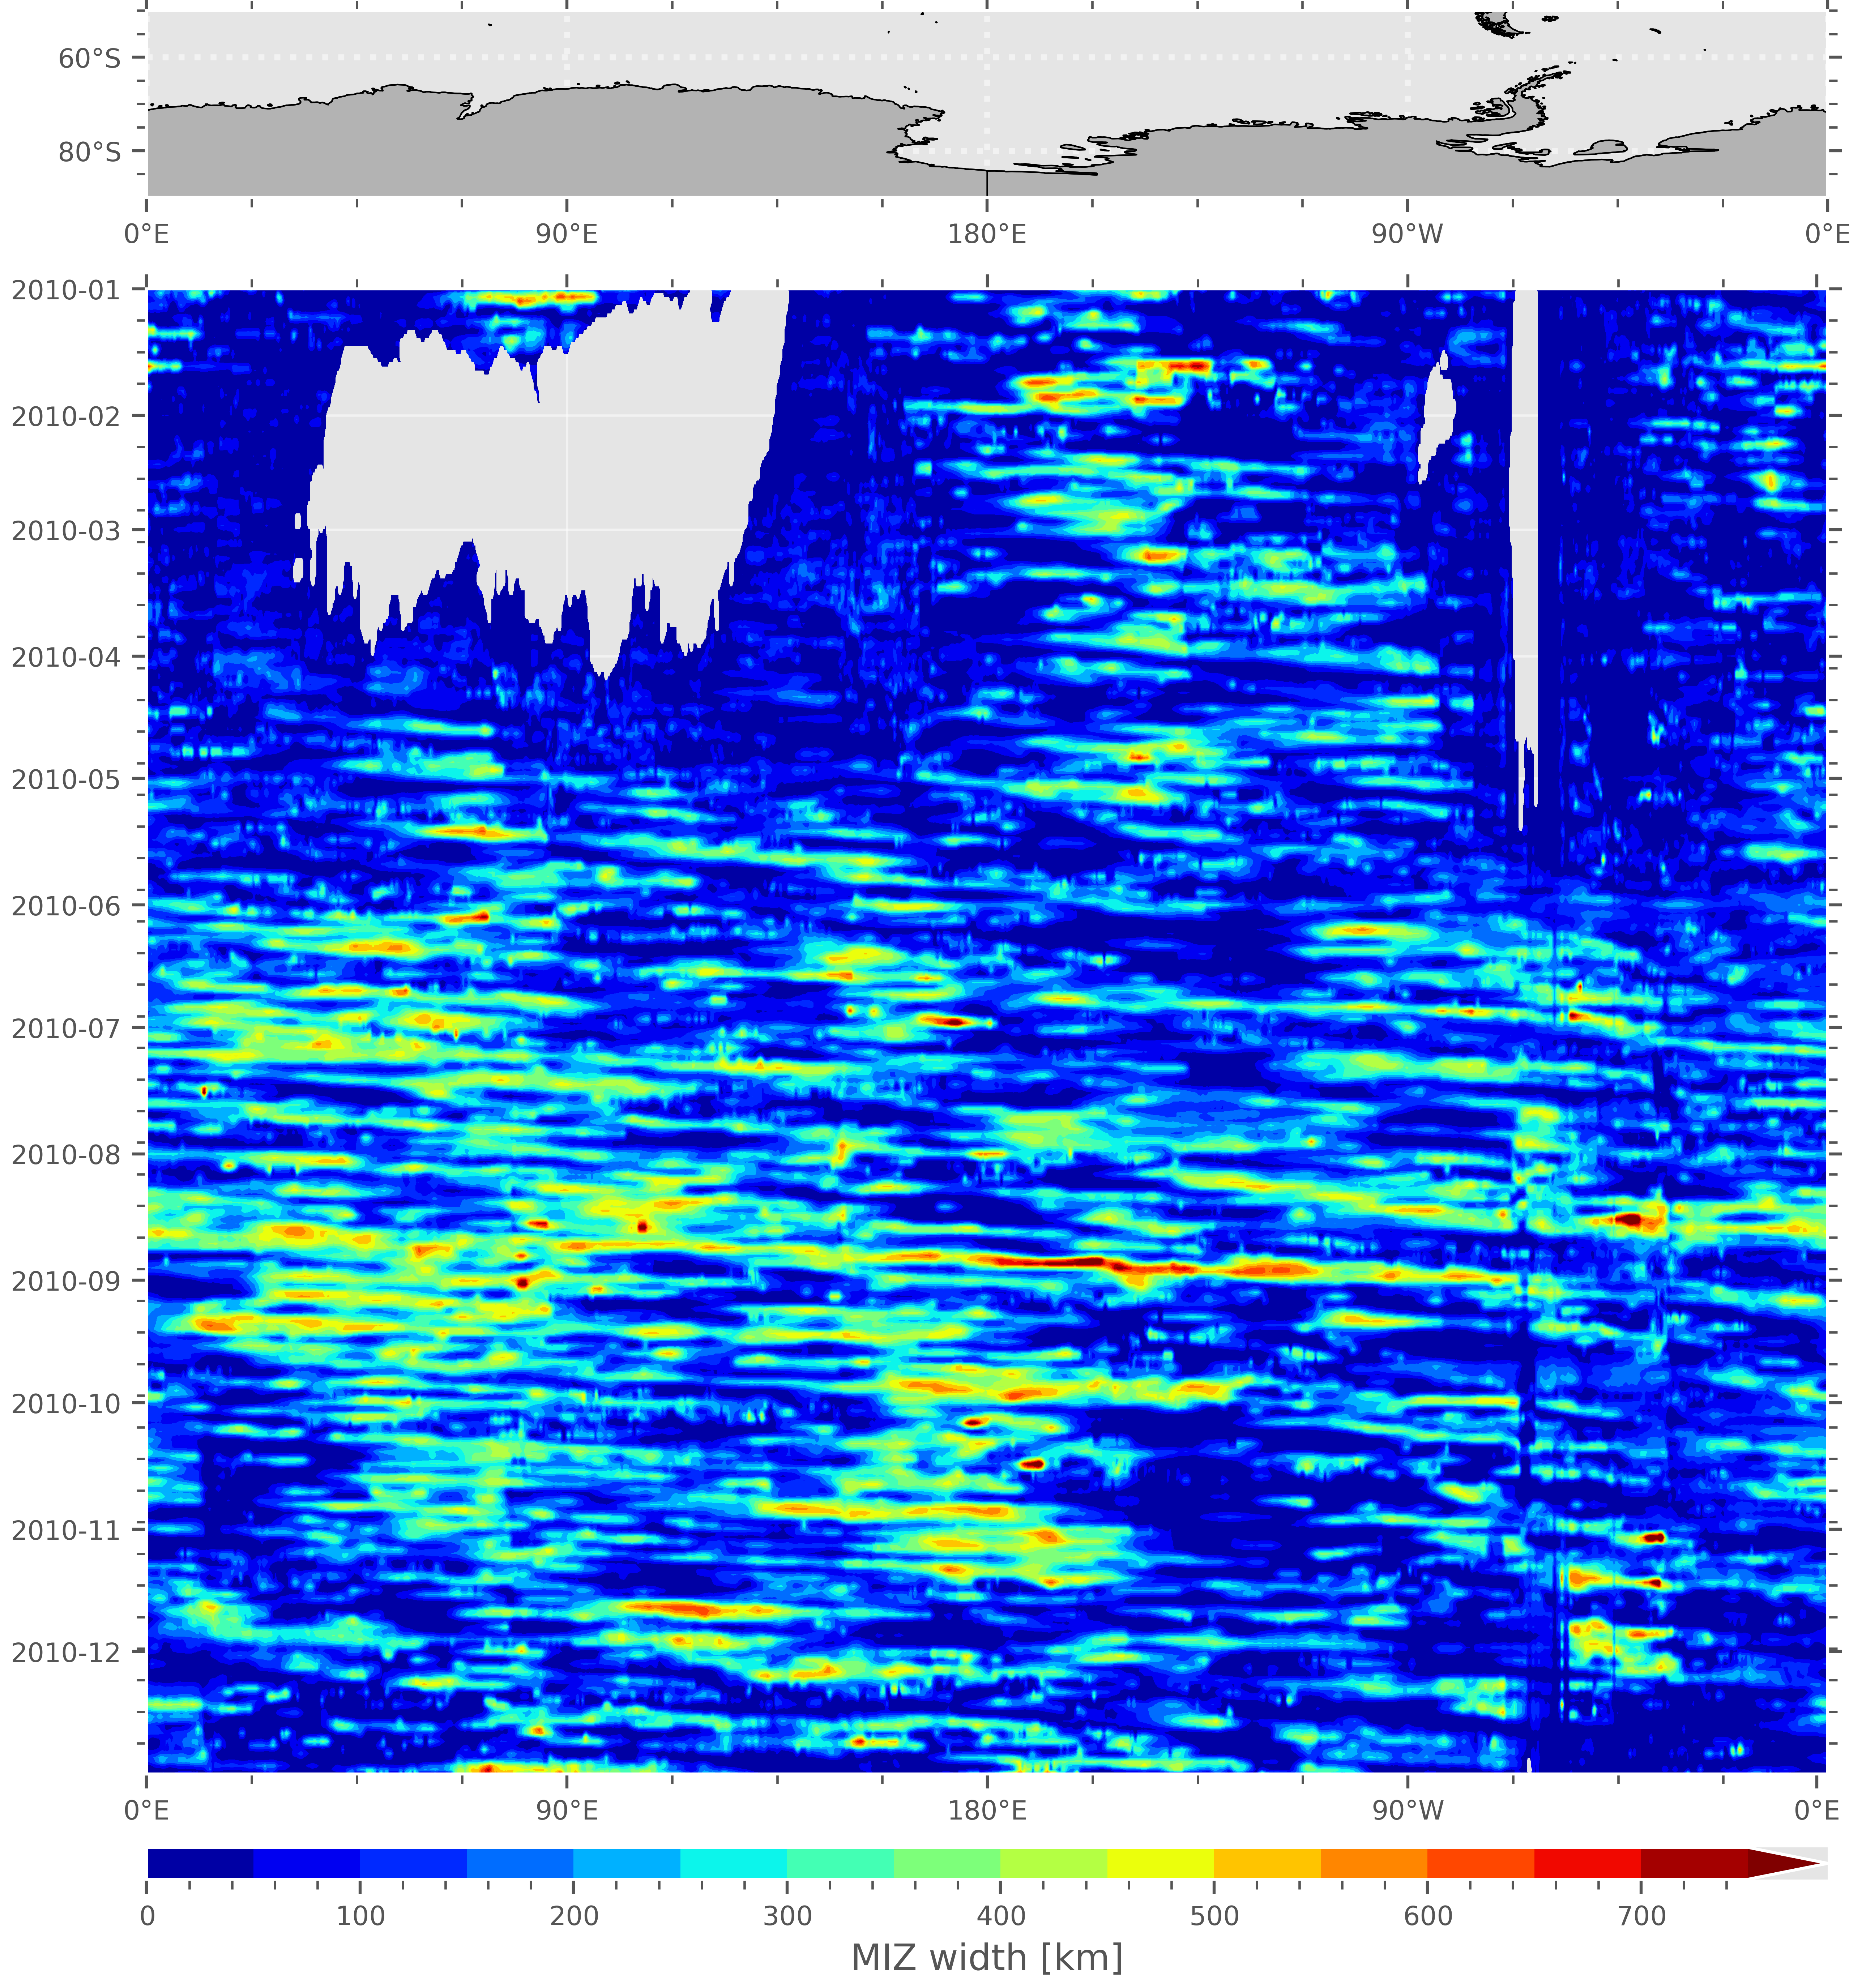

In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import numpy as np
import xarray as xr

fig = plt.figure(figsize=(10, 13))

ds = xr.open_dataset('/g/data/ia40/cice-dirs/runs/waves-025/history/iceh.2000-01-01.nc')
lons = ds['TLON'][0,:]
dates = pd.date_range(start="2010-01-01",end="2010-12-31", freq='d')

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)
# Tick labels
x_tick_labels = [u'0\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'180\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}E']

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([0, 357.5, -90, -50], ccrs.PlateCarree(central_longitude=180))
ax1.set_yticks([-80, -60])
ax1.set_yticklabels([u'80\N{DEGREE SIGN}S', u'60\N{DEGREE SIGN}S'])
ax1.set_xticks([-180, -90, 0, 90, 180])
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='dotted', linewidth=2)
COLOR_LAND = (0.7, 0.7, 0.7)
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                        edgecolor='black', facecolor=COLOR_LAND, linewidth=0.5)
ax1.add_feature(land_50m)

# Add geopolitical boundaries for map reference
ax1.add_feature(cft.COASTLINE.with_scale('50m'))
ax1.add_feature(cft.LAKES.with_scale('50m'), color='black', linewidths=0.5)

# Bottom plot for Hovmoller diagram
ax2 = fig.add_subplot(gs[1, 0])
ax2.invert_yaxis()  # Reverse the time order to do oldest first
cmap = mpl.cm.jet
max_pen = 800
norm = mpl.colors.Normalize(vmin=0, vmax=max_pen)

clevs = np.arange(0, max_pen, 50)

# Shift the data
if n_lon == 1440:
    diff = 1121 # 1/4-degree
else:
    diff = 280 # 1-degree

cf = ax2.contourf(lons.roll(ni=-diff), dates, mpcalc.smooth_n_point(
                  data_xr.roll(ni=-diff), 9, 1), clevs, cmap=cmap, extend='max')
#clevs = np.arange(0, max_pen, 100)
#cs = ax2.contour(lons.roll(ni=-diff), dates, mpcalc.smooth_n_point(
#                 data_xr.roll(ni=-diff), 9, 1), clevs, colors='k', linewidths=0.1, extend='max')


#cf = ax2.contourf(lons.roll(ni=-diff), dates, data_xr.roll(ni=-diff), clevs, cmap=cmap, extend='max')



# Make some ticks and tick labels
ax2.set_xticks([0, 90, 180, 270, 357.5])
ax2.set_xticklabels(x_tick_labels)

cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=False)
cbar.set_label('MIZ width [km]')

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'hovmoller_025_daily_' + str(year) + '.png', dpi = 600, bbox_inches="tight")

In [29]:
#print(wave_penetration_array)
#np.set_printoptions(threshold=sys.maxsize)
aice_distance_array_np = np.multiply(aice, hte)
idx = aice_distance_array_np.sum(dim='nj') < 0.0001

temp_wave_pen = swh_penetration_array_np.sum(dim='nj')
temp_wave_pen[idx] = np.nan
temp_wave_pen

<xarray.DataArray (ni: 360)>
array([            nan,             nan,             nan,  60832.234375  ,
                   nan,             nan,             nan,             nan,
                   nan,  59166.546875  ,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,  60832.234375  ,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan, 130106.        , 130106.        ,
       133510.96875   , 133510.96875   ,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
...
       153467.85546875, 100767.85546875,             nan,  48130.87890625,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan, 110170.37890625, 220388.12890625,
        57517.75      ,  59166.546875  ,             nan,             nan,
                   nan,  60832.234375  ,  60832.234375  ,  60832.234375  ,
        62512.04296875,  62512.04296875,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan, 123344.27734375, 187547.45703125,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,  74429.4609375 , 147159.2734375 ,
       218183.7578125 , 218183.7578125 , 218183.7578125 , 147159.2734375 ,
        72729.8125    ,  72729.8125    ,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan])
Coordinates:
    time     datetime64[ns] 2020-01-01
Dimensions without coordinates: ni

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
#df['0']

ax = sns.lineplot(x = LN[0,:], y=wave_penetration_array[0,:]/1000, linewidth=0.5)
ax = sns.lineplot(x = LN[0,:], y=wave_penetration_array[180,:]/1000, linewidth=0.5)
ax = sns.lineplot(x = LN[0,:], y=wave_penetration_array[300,:]/1000, linewidth=0.5, color='g')
#ax.set(ylim=((0,200)))
#plt.show()

In [ ]:
df

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize



ax = sns.heatmap(wave_penetration_array[:,:]/1000, linewidth=0.0, vmax=600)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 13))
ax = fig.add_subplot()
data_xr = xr.DataArray(wave_penetration_array, dims=["time", "ni"])

cf = ax.contourf(lons.roll(ni=-1121), dates, 
                 data_xr.roll(ni=-1121)*0.001, clevs, cmap=cmap, extend='both')
plt.show()
#cf = ax.contourf(lons, dates, mpcalc.smooth_n_point(
#    wave_penetration_array*0.001, 9, 5), clevs, cmap=cmap, extend='both')

In [ ]:
#lons[1121]
#lons
lons.roll(ni=-1121)
#lons

In [ ]:
lons

In [ ]:
import cartopy.feature as cft


fig = plt.figure(figsize=(10, 13))
#ax = fig.add_subplot()
ds = xr.open_dataset('/g/data/ia40/cice-dirs/runs/waves-025/history/iceh.2019-06-30.nc')
lons = ds['TLON'][0,:]
dates = pd.date_range(start="2019-01-01",end="2019-12-31", freq='d')

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=3, ncols=1, height_ratios=[3, 3, 3], hspace=0.003)
# Tick labels
x_tick_labels = [u'0\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'180\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}E']

# Top plot for geographic reference (makes small map)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([0, 357.5, -90, -50], ccrs.PlateCarree(central_longitude=180))
ax1.set_yticks([-80, -60])
ax1.set_yticklabels([u'80\N{DEGREE SIGN}S', u'60\N{DEGREE SIGN}S'])
ax1.set_xticks([-180, -90, 0, 90, 180])
ax1.set_xticklabels(x_tick_labels)
ax1.grid(linestyle='dotted', linewidth=2)
COLOR_LAND = (0.7, 0.7, 0.7)
#land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
#                        edgecolor='black', facecolor=COLOR_LAND, linewidth=0.5)
#ax1.add_feature(land_50m)

# Add geopolitical boundaries for map reference
#ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
#ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.5)
cs = ax1.pcolormesh(ds['TLON'][:,:],ds['TLAT'][:,:],ds['wave_sig_ht'][0,:,:]>0.01,
                    transform=ccrs.PlateCarree(), shading='auto',
                    cmap=cmap,
                    vmin=0, vmax=5)



ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=180))
ax2.set_extent([0, 357.5, -90, -50], ccrs.PlateCarree(central_longitude=180))
ax2.set_yticks([-80, -60])
ax2.set_yticklabels([u'80\N{DEGREE SIGN}S', u'60\N{DEGREE SIGN}S'])
ax2.set_xticks([-180, -90, 0, 90, 180])
ax2.set_xticklabels(x_tick_labels)
ax2.grid(linestyle='dotted', linewidth=2)
COLOR_LAND = (0.7, 0.7, 0.7)
#land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
#                        edgecolor='black', facecolor=COLOR_LAND, linewidth=0.5)
#ax1.add_feature(land_50m)

# Add geopolitical boundaries for map reference
#ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))
#ax1.add_feature(cfeature.LAKES.with_scale('50m'), color='black', linewidths=0.5)
cs = ax2.pcolormesh(ds['TLON'][:,:],ds['TLAT'][:,:],ds['aice'][0,:,:],
                    transform=ccrs.PlateCarree(), shading='auto',
                    cmap=cmap,
                    vmin=0, vmax=1)

# Bottom plot for Hovmoller diagram
ax3 = fig.add_subplot(gs[2, 0])
#ax2.invert_yaxis()  # Reverse the time order to do oldest first

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=1200)

clevs = np.arange(0, 1200, 100)


#cs = ax1.contour(ds['TLON'][:,:],ds['TLAT'][:,:],ds['aice'][0,:,:], colors='k', linewidths=1)

sns.lineplot(ax=ax3, x = LN[0,:], y=wave_penetration_array[100,:]/1000, linewidth=0.5)

sns.lineplot(ax=ax3, x = LN[0,:], y=test_pen, linewidth=0.5, color='b')

# Make some ticks and tick labels
ax3.set_xticks([0, 90, 180, 270, 357.5])

#cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
#cbar.set_label('MIZ width [km]')

savepath = '/home/566/nd0349/notebooks/'
plt.savefig(savepath+'test_mizwidth.png', dpi = 600, bbox_inches="tight")

In [ ]:
#wave_penetration_array
test_pen = np.empty(1440)
for idx in tqdm(range(1440)):
    temp = np.multiply(ds['wave_sig_ht'][0,:,idx]>0.05, ds['aice'][0,:,idx]>0.15)
    test_pen[idx] = np.multiply(temp, ds['HTE'][:,0]).sum()/1000

wave_penetration_array[99:102,0]/1000

In [ ]:
# 1. Take the Southern hemisphere
hte = ds.HTE.where(lat<0, drop=True).squeeze() 
aice_south = ds.aice.where(lat<0, drop=True).squeeze() 
swh_south = ds.wave_sig_ht.where(lat<0, drop=True).squeeze() 
wave_penetration_temp = ones_array.where(lat<0, drop=True).squeeze() 

# 2. aice > 0.15
hte = hte.where(aice_south > 0.15, drop=False)
aice = aice_south.where(aice_south > 0.15, drop=False)
swh_aice = swh_south.where(aice_south > 0.15, drop=False)
wave_penetration_temp_aice = wave_penetration_temp.where(aice_south > 0.15, drop=False)

# 3. SWH > 0.05 cm
hte = hte.where(swh_aice > 0.05, drop=False)
aice = aice.where(swh_aice > 0.05, drop=False)
wave_penetration_temp_wave = wave_penetration_temp_aice.where(swh_aice > 0.05, drop=False)
swh = swh_aice.where(swh_aice > 0.05, drop=False)
 

#swh_penetration_array = wave_penetration_temp_wave.weighted(hte.fillna(0))
swh_penetration_array_np = np.multiply(wave_penetration_temp_wave, hte)
swh_penetration_array_np.sum(dim='nj')

In [ ]:
sns.lineplot(x = LN[0,:], y=swh_penetration_array_np.sum(dim='nj')/1000, linewidth=0.5, color='k')
sns.lineplot(x = LN[0,:], y=test_pen, linewidth=0.5, color='b', linestyle='--')

# Checking WW3

In [ ]:
filename = '/g/data/ia40/cice-dirs/input/CICE_data/forcing/access-om2-10/CAWCR/2019/ww3_om2_10deg_20190101.nc'
ds = xr.open_dataset(filename)

filename = '/g/data/ia40/cice-dirs/input/CICE_data/forcing/access-om2-10/CAWCR/2019/ww3_om2_10deg_20190201.nc'
ds2 = xr.open_dataset(filename)
ds

In [9]:
filename = '/g/data/ia40/cice-dirs/input/CICE_data/forcing/access-om2-025/CAWCR/2016/ww3_om2_025deg_20160101.nc'
ds = xr.open_dataset(filename)

filename = '/g/data/ia40/cice-dirs/input/CICE_data/forcing/access-om2-025/CAWCR/2016/ww3_om2_025deg_20160201.nc'
ds2 = xr.open_dataset(filename)
ds

<xarray.Dataset>
Dimensions:  (time: 24, dim_j: 1080, dim_i: 1440)
Coordinates:
  * time     (time) datetime64[ns] 2041-12-31T01:00:00 ... 2016-01-01T23:00:00
    LON      (dim_j, dim_i) float64 ...
    LAT      (dim_j, dim_i) float64 ...
Dimensions without coordinates: dim_j, dim_i
Data variables:
    dir      (time, dim_j, dim_i) float32 ...
    fp       (time, dim_j, dim_i) float32 ...
    hs       (time, dim_j, dim_i) float32 ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Sep 20 16:38:54 2023: cdo seltimestep,1/24 MONTHLY/ww3_...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...

Text(0.5, 1.01, 'nc')

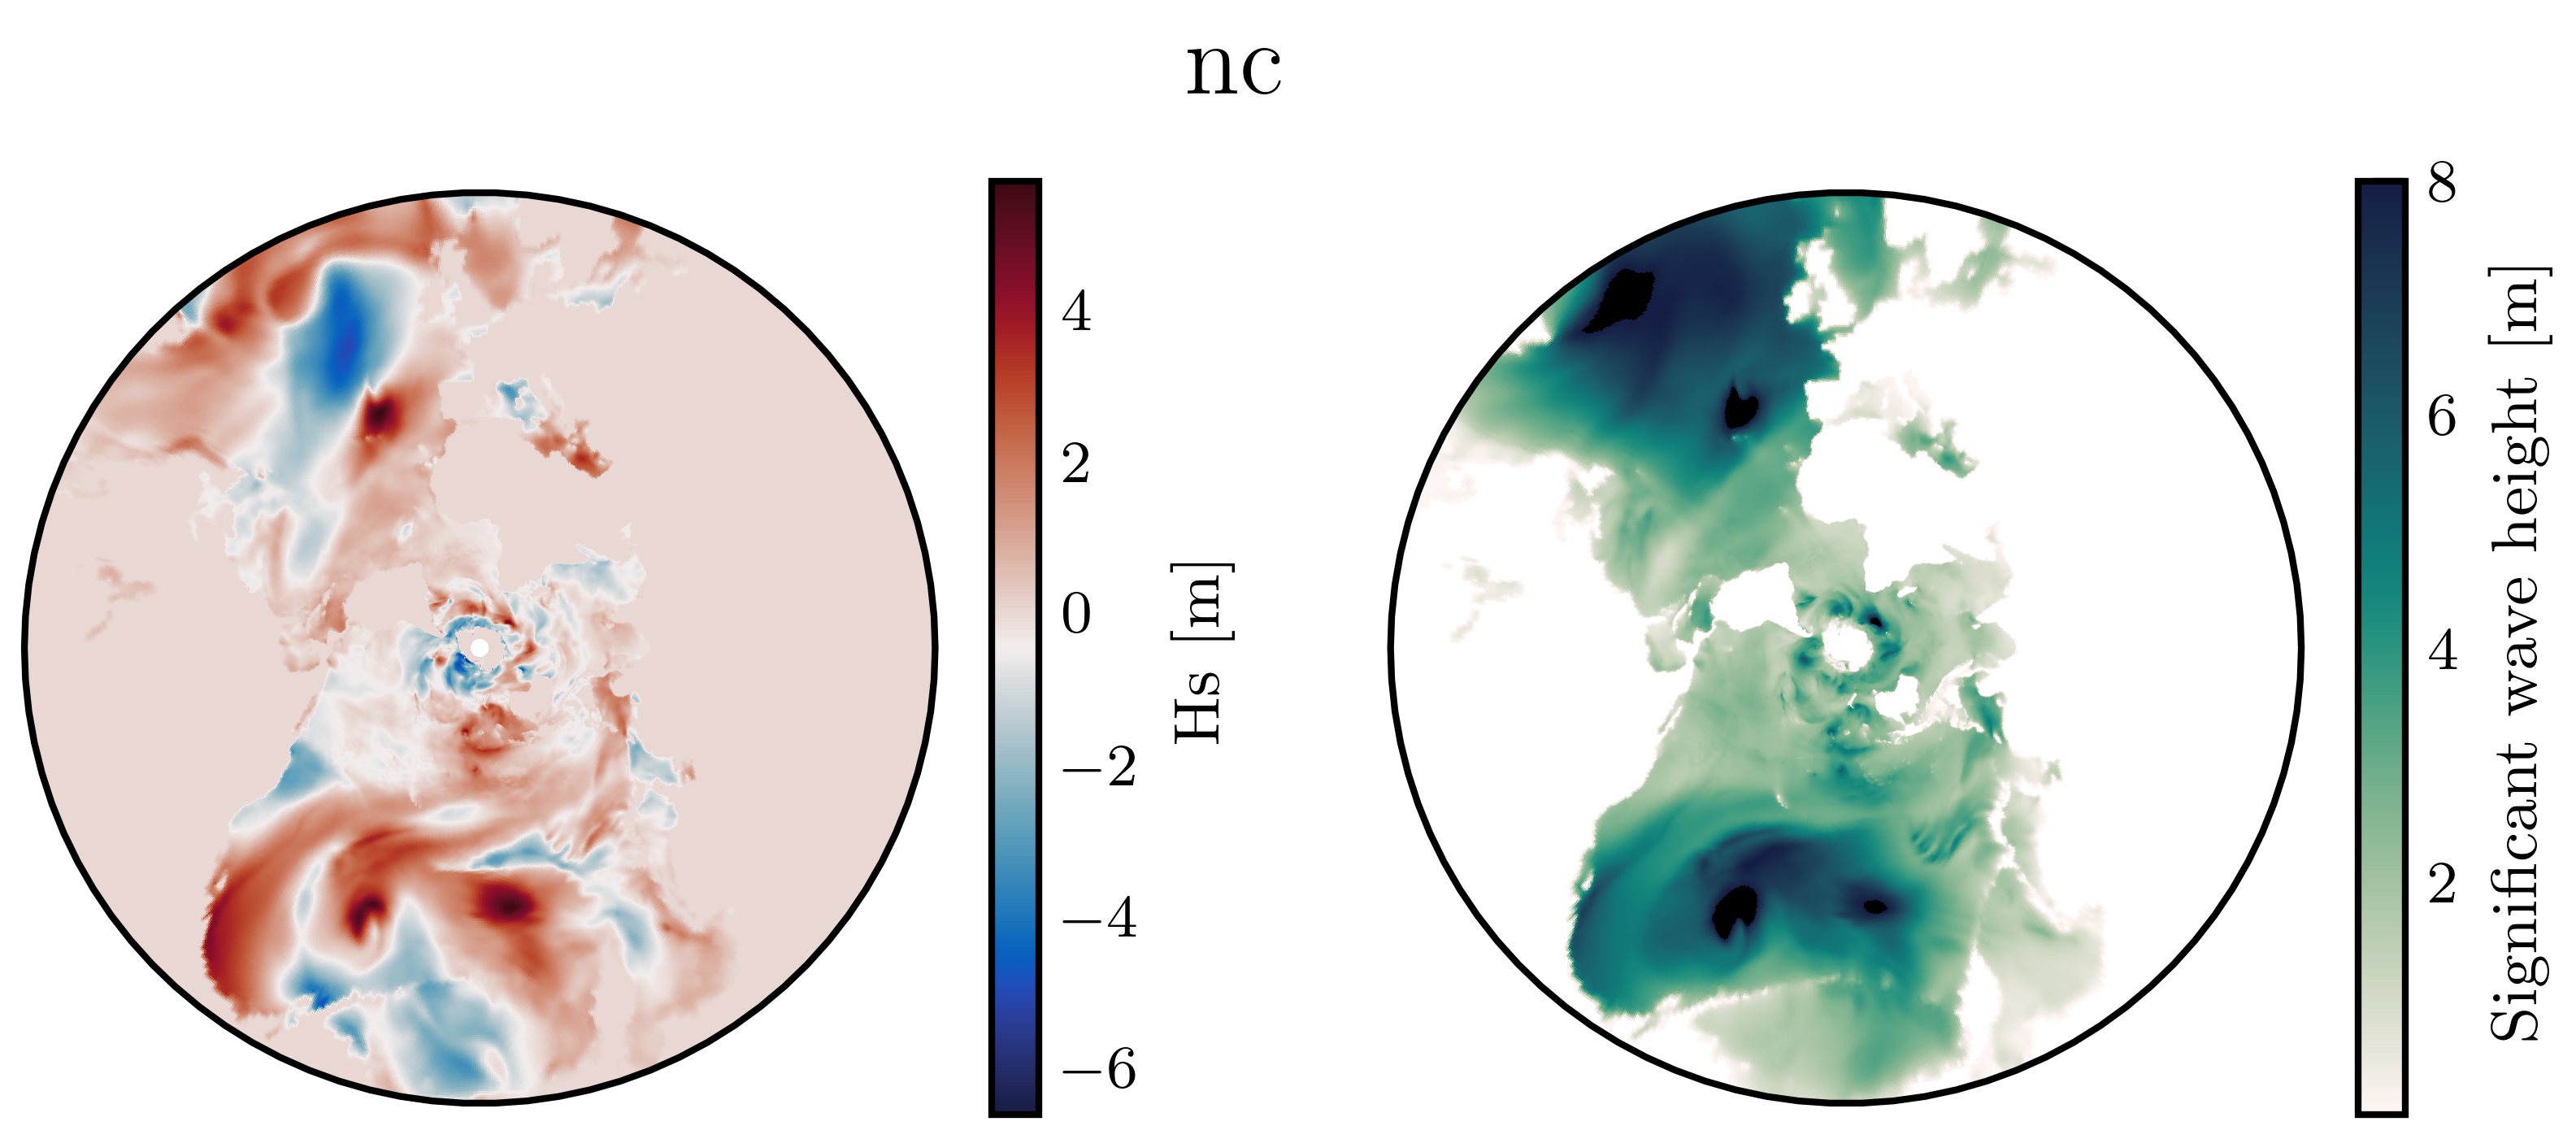

In [10]:
# Plot settings
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
textwidth = 3.31314*2
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

#plt.style.use("seaborn")



plt.style.use('default')
plt.style.use(['science','ieee', 'grid'])
sns.set_context("paper")
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
font_size = 14
mpl.rcParams.update({'font.size': font_size})
mpl.rcParams.update({"axes.grid" : True, "grid.color": [0.6, 0.6, 0.6]})
sns.color_palette("colorblind",15)

ds_mask = xr.open_dataset(filename)
LT = ds_mask['LAT']
LN = ds_mask['LON']
#land_mask = ds_mask['tmask'].where(ds_mask['tmask'][:,:] != 1.) 
#del ds_mask

savepath = '/home/566/nd0349/notebooks/figures/'

fig = plt.figure(figsize=[width, height/2])
ax1 = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())

#ax1 = create_map_axis(ax=ax1, LN=LN, LT=LT, land_mask=land_mask, draw_labels="left")
#ax2 = create_map_axis(ax=ax2, LN=LN, LT=LT, land_mask=land_mask, draw_labels="middle")

#Qfontprops = fm.FontProperties(size=18)
#plt.figure()
cmap = cmo.tempo

cmap.set_bad('white',0.)
cmap.set_over('black',1.0)
cmap.set_under('white',0.)



p = ax1.pcolormesh(LN, LT, ds['hs'][0,:,:]-ds2['hs'][0,:,:],
                transform=ccrs.PlateCarree(),
                cmap=cmo.balance,
#                norm=colors.LogNorm(vmin=1, vmax=1000),
                shading='auto')

fig.colorbar(p, ax=ax1, label = 'Hs [m]')

p2 = ax2.pcolormesh(LN, LT, ds['hs'][0,:,:],
                transform=ccrs.PlateCarree(),
                cmap=cmap, vmin = 0.000001, vmax = 8,
                shading='auto')
#cb = plt.colorbar(p, orientation='vertical', fraction=0.046, pad=0.04)
fig.colorbar(p2, ax=ax2, label = 'Significant wave height [m]')

temp = filename.partition('.')[2]
fig.suptitle(temp.partition('.')[0], fontsize=15, x=0.5, y = 1.01)

#plt.savefig(savepath+'aice_fsdrad_hour.png', dpi = 300)  